# Fifty Victorian Era Novelists Authorship Attribution Data

L'attribuzione della paternità è il processo di identificazione dell'autore di un determinato testo e ha applicazioni pratiche in vari settori, tra cui studi letterari, linguistica forense e rilevamento del plagio. Può aiutare a identificare la vera paternità di testi contestati o a assistere nell'analisi delle opere letterarie.

Da un punto di vista generale, i problemi di attribuzione della paternità si riferiscono a tutte le questioni che sorgono nell'associazione di un autore a un documento specifico. Un esempio comune è che quando viene scoperto un pezzo di testo storico vorremmo sapere chi l'ha scritto e quando è stato scritto. Oltre a ciò, potremmo anche porre altre domande come la nazionalità dell'autore, gli stili caratteristici dell'autore, il genere del testo.

L'attribuzione dell'autore dal punto di vista del machine learning può essere visto come un problema di classificazione e può essere un problema impegnativo, specialmente quando si tratta di testi del passato, come la letteratura dell'era vittoriana. Lo stile di scrittura e l'uso del linguaggio degli autori di quell'epoca possono essere complessi e sfumati. Inoltre, alcuni testi potrebbero aver subito modifiche nel corso del tempo, rendendo più difficile l'attribuzione.

L'obiettivo del nostro progetto è l'identificazione dell'autore di un determinato testo utilizzando i dati presi da https://dataworks.iupui.edu/handle/11243/23.
Vengono fornite le opere di 50 noti autori di epoca vittoriana. Tutte queste opere estratte sono romanzi. Per creare un problema di apprendimento non esaustivo, vengono forniti 45 autori nel training e 50 autori nei dati di test, i 5 autori mancanti nei test rappresentano il 34% di tutto il set di test. Ogni istanza è poi rappresentata con testi di 1000 parole per ogni autore. Ci sono 93600 istanze di pezzi di testo in totale, ciascuna composta da 1000 parole.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import spacy
from nltk.corpus import stopwords
from nltk.corpus import words
import warnings
warnings.filterwarnings('ignore')
import scipy.io
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import LabelEncoder
from nltk.util import ngrams
from collections import Counter
from nltk import word_tokenize
from tabulate import tabulate
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import decomposition, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from kneed import KneeLocator
from scipy.sparse import hstack, csr_matrix
import scikitplot as skplt
from IPython.display import HTML

Carichiamo il training set e il test set da un file CSV

In [104]:
train_df = pd.read_csv("files/train.csv",encoding = "ISO-8859-1")
test_df = pd.read_csv("files/test.csv",encoding = "ISO-8859-1")
test_author = scipy.io.loadmat("files/test_author.mat")["test_author"]

## Author Distribution

Di seguito, analizziamo la struttura e la distribuzione degli autori del nostro dataset:

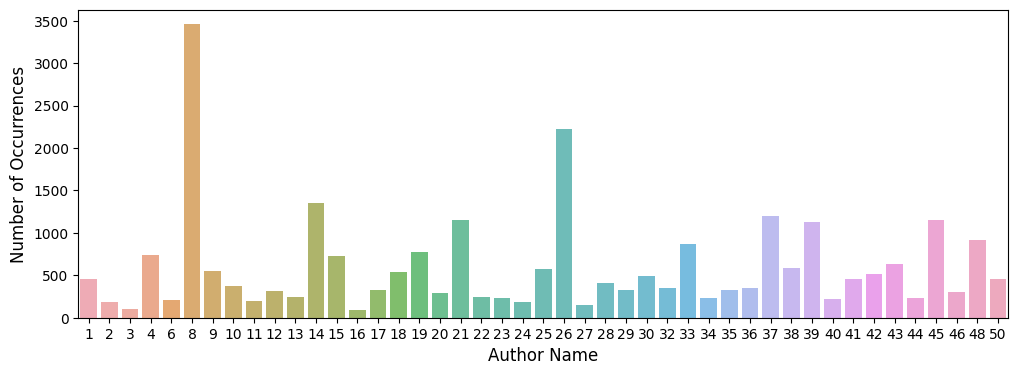

In [ ]:
cnt_srs = train_df['author'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [ ]:
f = open('files/author_list.txt', 'r')
author_list = f.read().split('\n')
f.close()
for author in author_list:
    print(author_list.index(author)+1, author)

1 Arthur Conan Doyle
2 Charles Darwin
3 Charles Dickens
4 Edith Wharton
5 George Eliot
6 Horace Greeley
7 Jack London
8 James Baldwin
9 Jane Austen
10 John Muir
11 Joseph Conrad
12 Mark Twain
13 Nathaniel Hawthorne
14 Ralph Emerson
15 Robert Louis Stevenson
16 Rudyard Kipling
17 Sinclair Lewis
18 Theodore Dreiser
19 Thomas Hardy
20 Walt Whitman
21 Washington Irving
22 William Carleton
23 Albert Ross
24 Anne Manning
25 Arlo Bates
26 Bret Harte
27 Catharine Maria Sedgwick
28 Charles Reade
29 Edward Eggleston
30 Fergus Hume
31 Frances Hodgson Burnett
32 George Moore
33 George William Curtis
34 Helen Mathers
35 Henry Rider Haggard
36 Isabella Lucy Bird
37 Jacob Abbott
38 James Grant
39 James Payn
40 John Kendrick Bangs
41 John Pendleton Kennedy
42 John Strange Winter
43 Lucas Malet
44 Marie Corelli
45 Oliver Optic
46 Sarah Orne Jewett
47 Sarah Stickney Ellis
48 Thomas Anstey Guthrie
49 Thomas Nelson Page
50 William Black


In [ ]:
print("Training sample number: ", train_df.shape)
print("Test sample number: ", test_df.shape)

Training sample number:  (26852, 2)
Test sample number:  (19394, 1)


In [ ]:
train_df.head(5)

,text,author
0,ou have time to listen i will give you the ent...,1
1,wish for solitude he was twenty years of age a...,1
2,and the skirt blew in perfect freedom about th...,1
3,of san and the rows of shops opposite impresse...,1
4,an hour s walk was as tiresome as three in a s...,1


In [ ]:
print(train_df['author'].unique())

[1 2 3 4 6 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 48 50]


In [106]:
#autori mancanti
missing_authors = [item for item in list(range(1,51)) if item not in train_df.author.unique().tolist()]
print(missing_authors)

[5, 7, 31, 47, 49]


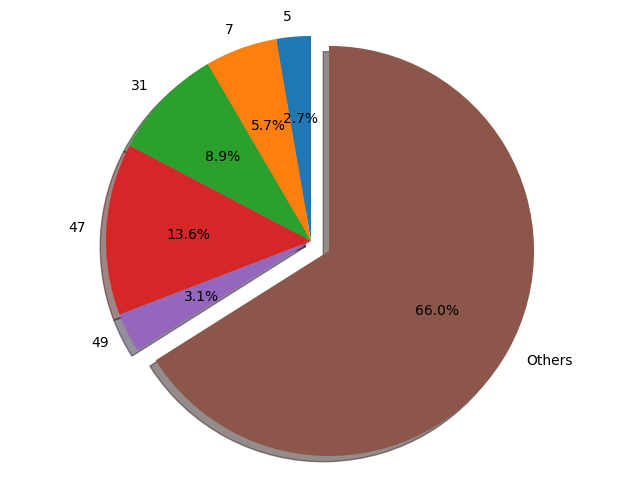

In [ ]:
#rapporto autori mancanti nei test
labels = [str(x) for x in missing_authors]
sizes = [len(test_author[test_author==x])/len(test_author)*100 for x in missing_authors]
labels.append("Others")
sizes.append(100-sum(sizes))
explode = (0, 0, 0, 0, 0, 0.1)

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

Ripuliamo il test set eliminando i 5 autori mancanti nel training set

In [107]:
# Unisci il tuo set di dati di test con le etichette degli autori
test_df['author'] = test_author

# Filtra il dataset di test per escludere gli autori specificati
new_test_df = test_df[~test_df['author'].isin(missing_authors)]

# Aggiorna le etichette
new_test_author = new_test_df['author']
print(new_test_df['author'].unique())

# elimina la colonna author dal test set
new_test_df = new_test_df.drop('author', axis=1)

[ 1  2  3  4  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 48 50]


In [108]:
new_test_df.shape

(12808, 1)

## Data Preprocessing
Nel dataset sono presenti molti caratteri non inglesi, convertiamo tali caratteri nelle loro controparti più vicine.

In [109]:
toEnglishDict = {}
srcStr = ['à','â','ä','å','æ','ç','è','é','ê','ë','ï','î','ñ','ô','ö','õ','ü','û','α','δ','ν','ο','π','ς','υ','ἶ']
dstStr = ['a','a','a','a','a','c','e','e','e','e','i','i','n','o','o','o','u','u','a','d','n','o','p','s','y','i']
for src,dst in zip(srcStr,dstStr):
    toEnglishDict[src] = dst

# converte tutti i caratteri non inglesi nelle loro controparti inglesi più vicine
def myunidecode(inString):
    outString = ''
    for ch in inString:
        if ch in toEnglishDict.keys():
            outString += toEnglishDict[ch]
        else:
            outString += ch
    return outString

sentences_train = []
sentences_test = []
sentences_new_test = []


for index, row in train_df.iterrows():
    sentence = row['text']
    decodedSentence = myunidecode(sentence)
    sentences_train.append(decodedSentence)

for index, row in test_df.iterrows():
    sentence = row['text']
    decodedSentence = myunidecode(sentence)
    sentences_test.append(decodedSentence)

for index, row in new_test_df.iterrows():
    sentence = row['text']
    decodedSentence = myunidecode(sentence)
    sentences_new_test.append(decodedSentence)


train_df['text'] = sentences_train
test_df['text'] = sentences_test
new_test_df['text'] = sentences_new_test

Rimuoviamo le stopwords dai testi

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [110]:
stop_words = set(stopwords.words('english'))

# Funzione per rimuovere le stopwords da un testo
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

train_df['text'] = train_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(remove_stopwords)
new_test_df['text'] = new_test_df['text'].apply(remove_stopwords)


## Bag of Words
Il Bag of Words (BoW) è una tecnica di rappresentazione dei dati testuali utilizzata nell'elaborazione del linguaggio naturale (NLP) e nel machine learning per la classificazione e l'analisi dei testi. L'idea principale di BoW è catturare l'informazione contenuta in un testo attraverso la frequenza delle parole presenti, senza considerare l'ordine o la struttura grammaticale delle frasi.

Di seguito utilizziamo BoW per l'estrazione delle features dai nostri testi e applichiamo i modelli Naive Bayes, Support Vector Machine, Logistic Regression e Gradient Boosting per il nostro problema di classificazione e li valutiamo utilizzando la metrica F1.

In [111]:
# Inizializza lista di punteggi f1
BoW_NGrams_f1_scores = []

# Vettorizzazione BOW
ctv = CountVectorizer(max_features=10000, ngram_range=(1, 3))

y_train = train_df['author'].values

x_train = ctv.fit_transform(train_df['text'])


## N-Grams
Gli N-Grams sono una tecnica utilizzata nell'analisi del linguaggio naturale e nell'elaborazione del linguaggio naturale (NLP) per estrarre sequenze di parole o caratteri da un testo. Sono usati per catturare informazioni sulla struttura e la co-occorrenza delle parole in un testo. Il termine N-gram si riferisce al numero di elementi (solitamente parole o caratteri) in ciascuna sequenza.

Considerare gli N-grams è utile poiché Bag of word perde l'ordine delle parole quando si considera un testo.

Di seguito mostriamo i bigrammi e i trigrammi più frequenti di alcuni autori.

In [ ]:
stop_words = set(stopwords.words('english'))

def Ngram1(text, n):
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

def NgramFreq(text,n,num):
    result = Ngram1(text,n)
    result_count = Counter(result)
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'})
    return df.sort_values(["frequency"],ascending=[0])[:num]

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = word_tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    return words

def GramTable(x, gram, length):
    out = pd.DataFrame(index=None)
    for i in gram:
        table = pd.DataFrame(NgramFreq(preprocessing(train_df[train_df.author == x]['text']),i,length).reset_index())
        table.columns = ["{}-Gram".format(i),"Occurence"]
        out = pd.concat([out, table], axis=1)
    return out

def print_table(data, headers):
    print(tabulate(data, headers, tablefmt="fancy_grid"))

# Esempio di utilizzo
table_1 = GramTable(x=1, gram=[2, 3], length=1)
table_2 = GramTable(x=2, gram=[2, 3], length=1)
table_3 = GramTable(x=3, gram=[2, 3], length=1)
table_4 = GramTable(x=4, gram=[2, 3], length=1)

# Sostituisci gli indici con i nomi degli autori
table_1.index = ['Arthur Conan Doyle'] * len(table_1)
table_2.index = ['Charles Darwin'] * len(table_2)
table_3.index = ['Charles Dickens'] * len(table_3)
table_4.index = ['Edith Wharton'] * len(table_4)

# Unisci le tabelle in un'unica tabella
merged_table = pd.concat([table_1, table_2, table_3, table_4])

# Stampa la tabella combinata
print_table(merged_table, headers=["2-Gram", "Occurrence", "3-Gram", "Occurrence"])

╒════════════════════╤════════════════╤══════════════╤══════════════════╤══════════════╕
│                    │ 2-Gram         │   Occurrence │ 3-Gram           │   Occurrence │
╞════════════════════╪════════════════╪══════════════╪══════════════════╪══════════════╡
│ Arthur Conan Doyle │ sugar princess │          295 │ love gone astray │           64 │
├────────────────────┼────────────────┼──────────────┼──────────────────┼──────────────┤
│ Charles Darwin     │ said mr        │          103 │ said mr good     │           12 │
├────────────────────┼────────────────┼──────────────┼──────────────────┼──────────────┤
│ Charles Dickens    │ bundle time    │          132 │ miss yes mr      │           24 │
├────────────────────┼────────────────┼──────────────┼──────────────────┼──────────────┤
│ Edith Wharton      │ could see      │          200 │ round red lamp   │          114 │
╘════════════════════╧════════════════╧══════════════╧══════════════════╧══════════════╛


### Naive Bayes
Il classificatore Naive Bayes è un algoritmo di classificazione supervisionata basato sul teorema di Bayes con l'assunzione "naive" o semplificatrice che tutte le features siano indipendenti tra loro, dato un certo valore della variabile target. Nonostante questa semplificazione eccessiva, il classificatore Naive Bayes è noto per la sua efficienza e può fornire buone prestazioni iniziali per molte applicazioni di classificazione.

Naive Bayes Multinomiale è una variante comunemente utilizzata per il riconoscimento di testi, dove le features rappresentano le frequenze delle parole. Si basa su una distribuzione multinomiale e funziona bene con dati discreti come conteggi di parole.

Prima di effettuare la classficazione facciamo una ricerca sugli iperparametri del modello, in questo caso sul parametro "alpha" che rappresenta il valore di addizione costante  utilizzato per evitare che le probabilità condizionate diventino zero in presenza di determinati dati, per trovare il valore di alpha che massimizza le prestazioni del modello Naive Bayes sul nostro dataset.

Migliori iperparametri: {'alpha': 0.25}


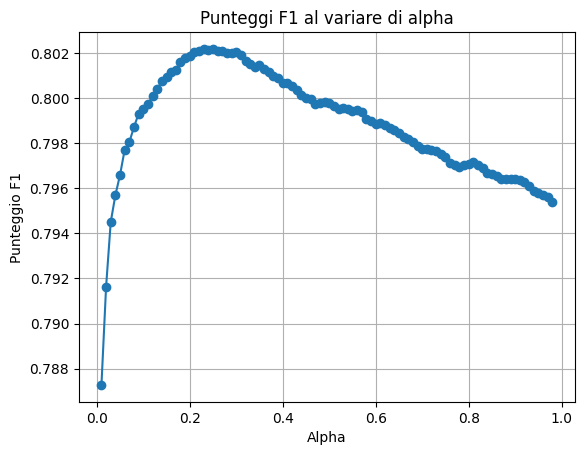

In [ ]:
# Crea una griglia di valori di alpha da provare
alpha_list=np.arange(start=0.01,stop=0.99,step=0.01)

param_grid = {
    'alpha': alpha_list
}

nb_model = MultinomialNB()

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, scoring='f1_micro', cv=5)
grid_search.fit(x_train, y_train)

print("Migliori iperparametri:", grid_search.best_params_)

best_alpha = grid_search.best_params_

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Plot dei punteggi F1 rispetto ai valori di alpha
plt.plot(alpha_list, scores, marker='o', linestyle='-')
plt.title('Punteggi F1 al variare di alpha')
plt.xlabel('Alpha')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.show()

Dividiamo il dataset in training set (70%) e validation set (30%), e valutiamo il modello Naive Bayes con alpha = 0.27 sul validation set

In [131]:
X_train,X_val,Y_train,Y_val = train_test_split(x_train, y_train, test_size=0.3)
print("Training sample number: ", X_train.shape)
print("Validation sample number: ", X_val.shape)

Training sample number:  (18796, 10000)
Validation sample number:  (8056, 10000)


In [132]:
nb_model = MultinomialNB(alpha=0.25)
# Valuta il modello ottimizzato sui dati di test
nb_model.fit(X_train, Y_train)
nb_pred = nb_model.predict(X_val)
f1 = f1_score(Y_val, nb_pred, average='micro')
BoW_NGrams_f1_scores.append(f1)
print("F1 Score Multinomial Naive bayes:", f1)

F1 Score Multinomial Naive bayes: 0.913604766633565


### Logistic Regression
La regressione logistica è un algoritmo di apprendimento automatico utilizzato per la classificazione binaria e multiclasse. Utilizza una funzione sigmoide per trasformare una combinazione lineare delle features in un valore compreso tra 0 e 1 e utilizza questo punteggio per effettuare la classificazione.
La regressione logistica è un buon punto di partenza per problemi di classificazione, specialmente quando si desidera avere una comprensione chiara delle influenze delle features sulla classificazione.

Vogliamo trovare il miglior classificatore di regressione logistica sul nostro dataset, perciò effettuiamo una ricerca grid sui parametri "C" e "penalty", dove "C" determina quanto il modello è penalizzato per adattarsi troppo ai dati di addestramento e "penalty" determina il tipo di norma di regolarizzazione da applicare nella regressione logistica (l1 o l2).

In genere, i valori di C da provare includono una gamma di valori che coprono diverse scale di regolarizzazione:

Piccoli valori di C: Valori come 0.001 o 0.01 rappresentano una forte regolarizzazione. Questi valori possono essere utili quando si vuole prevenire l'overfitting su dataset con molti attributi o dati rumorosi.

Valori intermedi di C: Valori come 0.1 o 1 rappresentano una regolarizzazione moderata. Questi valori sono spesso un buon punto di partenza quando non si è sicuri di quale regolarizzazione sia appropriata.

Grandi valori di C: Valori come 10 o 1000 rappresentano una regolarizzazione debole. Questi valori sono adatti quando si ha fiducia che il modello possa gestire bene i dati di addestramento senza overfitting..

Migliori iperparametri: {'C': 10, 'penalty': 'l2'}


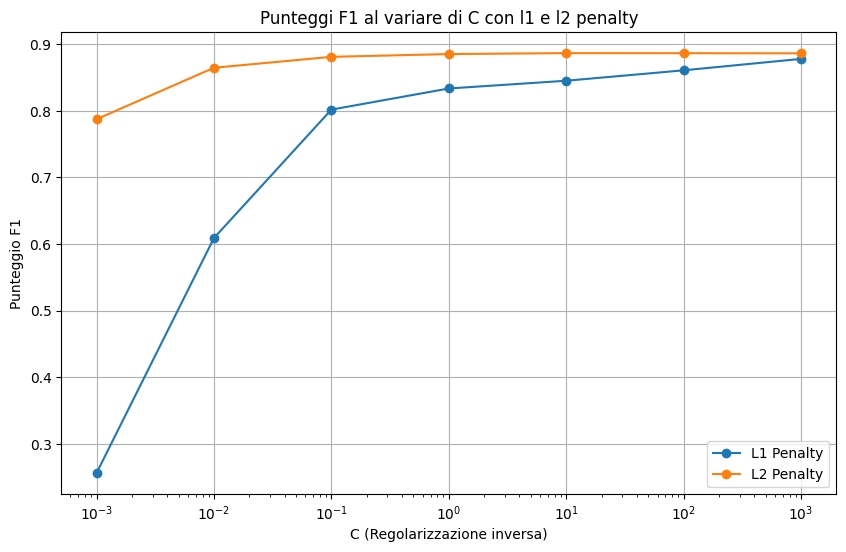

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # (regolarizzazione inversa)
    'penalty': ['l1','l2']          # Tipo di regolarizzazione
}

logistic_regression = LogisticRegression(solver='liblinear', max_iter=1000)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, scoring='f1_micro', cv=5)
grid_search.fit(x_train, y_train)

print("Migliori iperparametri:", grid_search.best_params_)

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']
param_range = param_grid['C']

l1_scores = scores[::2]  # Prendi i punteggi F1 per L1
l2_scores = scores[1::2]  # Prendi i punteggi F1 per L2

plt.figure(figsize=(10, 6))

# Plot dei punteggi F1 al variare di C
plt.plot(param_range, l1_scores, marker='o', linestyle='-', label='L1 Penalty')
plt.plot(param_range, l2_scores, marker='o', linestyle='-', label='L2 Penalty')

plt.title('Punteggi F1 al variare di C con l1 e l2 penalty')
plt.xlabel('C (Regolarizzazione inversa)')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.show()

Questa volta il modello si comporta meglio con un valore di C=10. Cerchiamo ora di trovare un valore più preciso eseguendo una ricerca grid su un intorno di 10.

Migliori iperparametri: {'C': 9, 'penalty': 'l2'}


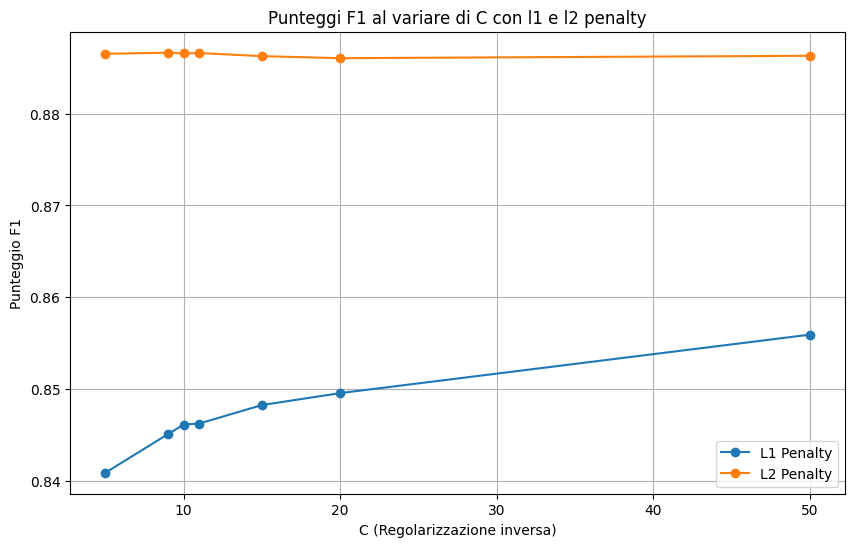

In [ ]:
# Crea una griglia di valori di C e penalty da provare
param_grid = {
    'C': [5, 9, 10, 11, 15, 20, 50],  # (regolarizzazione inversa)
    'penalty': ['l1', 'l2']          # Tipo di regolarizzazione
}

logistic_regression = LogisticRegression(solver='liblinear', max_iter=1000)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, scoring='f1_micro', cv=5)
grid_search.fit(x_train, y_train)

print("Migliori iperparametri:", grid_search.best_params_)

best_C = grid_search.best_params_['C']
best_penalty = grid_search.best_params_['penalty']

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']
param_range = param_grid['C']

l1_scores = scores[::2]  # Prendi i punteggi F1 per L1
l2_scores = scores[1::2]

plt.figure(figsize=(10, 6))

# Plot dei punteggi F1 al variare di C
plt.plot(param_range, l1_scores, marker='o', linestyle='-', label='L1 Penalty')
plt.plot(param_range, l2_scores, marker='o', linestyle='-', label='L2 Penalty')

plt.title('Punteggi F1 al variare di C con l1 e l2 penalty')
plt.xlabel('C (Regolarizzazione inversa)')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend()
plt.show()

La GridSearchCV trova un valore migliore di C, cioè 9, ma vediamo dal grafico che la differenza nel punteggio F1 è quasi impercettibile. Inoltre vediamo una leggera decrescita all'aumentare del valore di C da 10 in poi.

Addestriamo quindi il modello di regressione logistica con C=9 e regolarizzazione l2:

In [117]:
X_train,X_val,Y_train,Y_val = train_test_split(x_train, y_train, test_size=0.3)

logistic_regression = LogisticRegression(solver='liblinear', max_iter=1000, C=9, penalty='l2')

logistic_regression.fit(X_train, Y_train)
# Valuta il modello ottimizzato sul validation set
lr_pred = logistic_regression.predict(X_val)
f1 = f1_score(Y_val, lr_pred, average='micro')
BoW_NGrams_f1_scores.append(f1)
print("F1 Score Logistic Regression:", f1)

F1 Score Logistic Regression: 0.9767874875868917


### Support Vector Machine
Le SVM sono note per essere molto efficaci nella classificazione di dati complessi e non lineari. Possono trovare decisioni di separazione complesse anche in spazi ad alta dimensionalità. L'obiettivo principale delle SVM è massimizzare il margine tra le classi. Questo significa che le SVM cercano di massimizzare la "certezza" della classificazione, il che spesso si traduce in buone prestazioni sul test set. Tuttavia possono richiedere molto tempo di addestramento su dataset molto grandi, per questo motivo riduciamo la dimensionalità del nostro dataset utilizzando la Truncated Singular Value Decomposition (Truncated SVD), anche conosciuta come Principal Component Analysis (PCA) per matrici sparse.

La Truncated SVD è particolarmente adatta per matrici sparse, dove la maggior parte degli elementi è zero. Questo perché i calcoli sono più efficienti rispetto alla SVD standard.

Per trovare il numero di componenti principali adatto calcoliamo la varianza cumulativa spiegata per diversi numeri di componenti per trovare il numero minimo di componenti che mantiene una varianza cumulativa del 95%.

La varianza cumulativa spiegata è una misura che indica quanto della varianza totale nei dati è preservata dopo la riduzione dimensionale.

In [ ]:
n_components = 5000

svd = decomposition.TruncatedSVD(n_components=n_components)
svd.fit(x_train)

# Calcola la varianza cumulativa spiegata
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)

# Trova il numero di componenti necessarie per mantenere almeno il 95% di varianza
n_components_for_95_percent_variance = np.argmax(cumulative_explained_variance >= 0.95) + 1

print("Numero di componenti per mantenere il 95% di varianza:", n_components_for_95_percent_variance)

Numero di componenti per mantenere il 95% di varianza: 4694


Andiamo a ridurre il dataset a 4694 componenti

In [ ]:
# Riduzione del dataset
svd = decomposition.TruncatedSVD(n_components=4694)
svd.fit(x_train)
xtrain_svd = svd.transform(x_train)

# Normalizza i dati ottenuti da SVD
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)

addestrando la SVM con il dataset ridotto a 4694 componenti e effettuando le previsione sul validation set vediamo che il punteggio F1 è molto basso rispetto a quelli ottenuti in precedenza. Ciò significa che ci sono troppe componenti che fungono solo da rumore.

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(xtrain_svd_scl, y_train, test_size=0.3)

svm = SVC()
svm.fit(X_train, Y_train)

# Valuta il modello ottimizzato sui dati di test
svm_pred = svm.predict(X_val)
f1 = f1_score(Y_val, svm_pred, average='micro')
BoW_NGrams_f1_scores.append(f1)
print("F1 Score Support Vector Machine:", f1)

F1 Score Support Vector Machine: 0.6182969215491559


Andiamo perciò a cercare il punto in cui il punteggio F1 inizia a decrescere, addestrando la SVM con cross validation uguale a 5. 

Tuttavia vediamo che restringendo il numero di componenti fino a un massimo di 1000 non riusciamo ancora a trovare il punto in il punteggio F1 inizia a decrescere. Eseguiamo perciò un' analisi del gomito per trovare il punto in cui l'aumentare del punteggio F1 è meno significativo (Punto di Gomito)

Punto di Gomito: 300


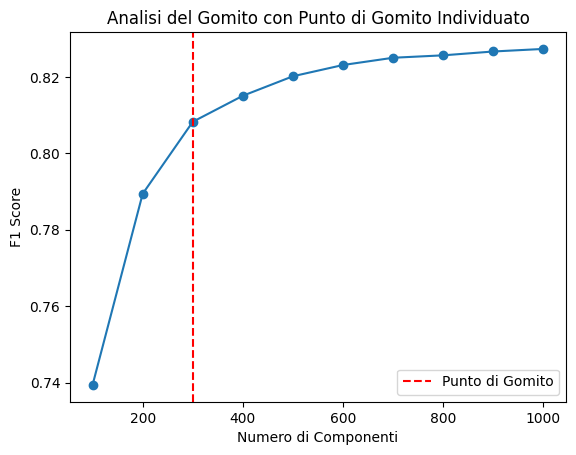

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(x_train, y_train, test_size=0.3)

components_range = np.arange(100, 1100, 100)

svm_model = SVC()

f1_scores = []

for n_components in components_range:
    svd = decomposition.TruncatedSVD(n_components=n_components)
    X_svd = svd.fit_transform(x_train)

    # Esegui la cross-validation con k=5
    cv_scores = cross_val_score(svm_model, X_svd, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1_micro')

    # Calcola la media dei punteggi F1 ottenuti durante ciascuna iterazione di cross-validation
    f1 = np.mean(cv_scores)
    f1_scores.append(f1)

# Trova il numero di componenti che massimizza il punteggio F1
best_n_components = components_range[np.argmax(f1_scores)]

# Utilizza KneeLocator per trovare il punto di gomito
kneedle = KneeLocator(components_range, f1_scores, curve='concave', direction='increasing')
elbow_point = kneedle.elbow

# Stampa il punto di gomito individuato
print(f"Punto di Gomito: {elbow_point}")

# Visualizza il grafico con il punto di gomito individuato
plt.plot(components_range, f1_scores, marker='o')
plt.xlabel('Numero di Componenti')
plt.ylabel('F1 Score')
plt.title('Analisi del Gomito con Punto di Gomito Individuato')
plt.axvline(x=elbow_point, color='r', linestyle='--', label='Punto di Gomito')
plt.legend()
plt.show()

 Andiamo a ridurre la dimensionalità del dataset a 300 componenti con la Truncated SVD. Tuttavia le nuove features (le componenti principali) possono avere scale diverse. Questo può essere problematico quando si addestrano modelli come le SVM, perciò normalizziamo i dati.

In [102]:
# Riduzione del dataset
svd = decomposition.TruncatedSVD(n_components=300)
svd.fit(x_train)
xtrain_svd = svd.transform(x_train)

# Normalizza i dati ottenuti da SVD
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)

Anche in questo caso effettuiamo una ricerca grid per trovare gli iperparametri "C" e "gamma" che massimizzano il modello Support Vector Machine sul nostro dataset.

Il parametro C regola la penalizzazione sull'errore del classificatore. Valori più elevati di C consentono al modello di adattarsi meglio ai dati di addestramento, ma possono portare a un potenziale overfitting. Valori più bassi di C impongono una maggiore regolarizzazione, che può aiutare a prevenire l'overfitting.

Il parametro gamma controlla la forma della funzione kernel. Valori più elevati di gamma producono una decision boundary più complessa, adatta ai dati di addestramento, ma possono portare a un potenziale overfitting. Valori più bassi di gamma producono una decision boundary più semplice

Migliori iperparametri: {'C': 100, 'gamma': 0.001}


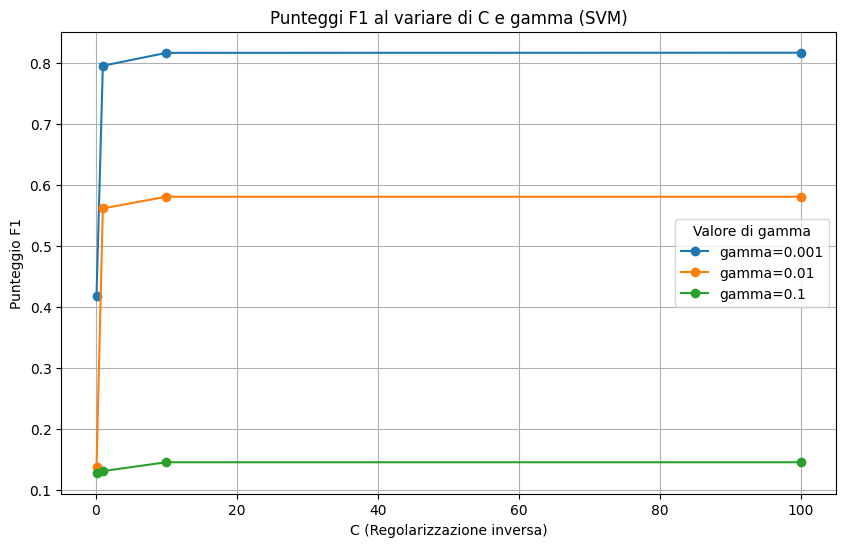

In [21]:
svm = SVC()

# Crea una griglia di valori di C e gamma da provare
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1]
}

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='f1_micro', cv=5)

# Addestra il modello con cross-validation
grid_search.fit(xtrain_svd_scl, y_train)

# Stampa i migliori iperparametri trovati
print("Migliori iperparametri:", grid_search.best_params_)

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Crea una griglia per i valori di C e gamma
param_grid = grid_search.param_grid
C_values = param_grid['C']
gamma_values = param_grid['gamma']

plt.figure(figsize=(10, 6))
for gamma_value in gamma_values:
    gamma_scores = scores[grid_search.cv_results_['param_gamma'] == gamma_value]
    plt.plot(C_values, gamma_scores, marker='o', label=f'gamma={gamma_value}')

plt.title('Punteggi F1 al variare di C e gamma (SVM)')
plt.xlabel('C (Regolarizzazione inversa)')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend(title='Valore di gamma')
plt.show()

Per raffinare ancor di più la ricerca degli iperparmetri andiamo ora a rieseguire una ricerca grid su un intorno di 100 per il parametro C.

Migliori iperparametri: {'C': 95, 'gamma': 0.001}


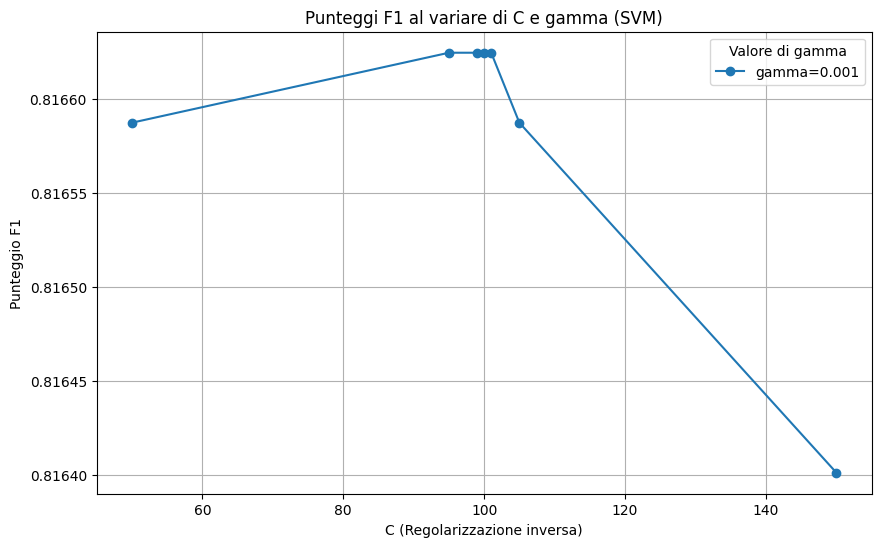

In [22]:
param_grid = {
    'C': [50, 95, 99, 100, 101, 105, 150],
    'gamma': [0.001]
}

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='f1_micro', cv=5)

# Addestra il modello con cross-validation
grid_search.fit(xtrain_svd_scl, y_train)

# Stampa i migliori iperparametri trovati
print("Migliori iperparametri:", grid_search.best_params_)

best_C_svm = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Crea una griglia per i valori di C e gamma
param_grid = grid_search.param_grid
C_values = param_grid['C']
gamma_values = param_grid['gamma']

plt.figure(figsize=(10, 6))
for gamma_value in gamma_values:
    gamma_scores = scores[grid_search.cv_results_['param_gamma'] == gamma_value]
    plt.plot(C_values, gamma_scores, marker='o', label=f'gamma={gamma_value}')

plt.title('Punteggi F1 al variare di C e gamma (SVM)')
plt.xlabel('C (Regolarizzazione inversa)')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend(title='Valore di gamma')
plt.show()

Abbiamo trovato dei valori migliori per C e gamma, rispettivamente 95 e 0.001. Vediamo tuttavia che la differenza è minima perciò non ho ritenuto necessario raffinare ulteriormente la ricerca.

In [116]:
X_train,X_val,Y_train,Y_val = train_test_split(xtrain_svd_scl, y_train, test_size=0.3)

svm = SVC(C=95, gamma=0.001)
svm.fit(X_train, Y_train)

# Valuta il modello ottimizzato sui dati di test
svm_pred = svm.predict(X_val)
f1 = f1_score(Y_val, svm_pred, average='micro')
BoW_NGrams_f1_scores.append(f1)
print("F1 Score Support Vector Machine:", f1)

F1 Score Support Vector Machine: 0.9302383316782522


### Gradient Boosting
Il Gradient Boosting è un algoritmo di machine learning estremamente popolare e potente basato su alberi decisionali. Grazie alla tecnica di boosting, può combinare molti alberi decisionali deboli per creare un modello forte e complesso che è in grado di fare previsioni accurate su una vasta gamma di problemi di machine learning. Inoltre è in grado di gestire automaticamente i dati mancanti.

Effettuiamo una ricerca grid sul numero di alberi da addestrare nel modello XGBoost ("n_estimators"), la massima profondità consentita per ciascun albero ("max_depth") e il "learning_rate" che controlla la quantità di contributo di ciascun albero al modello complessivo.

Migliori iperparametri: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 1000}


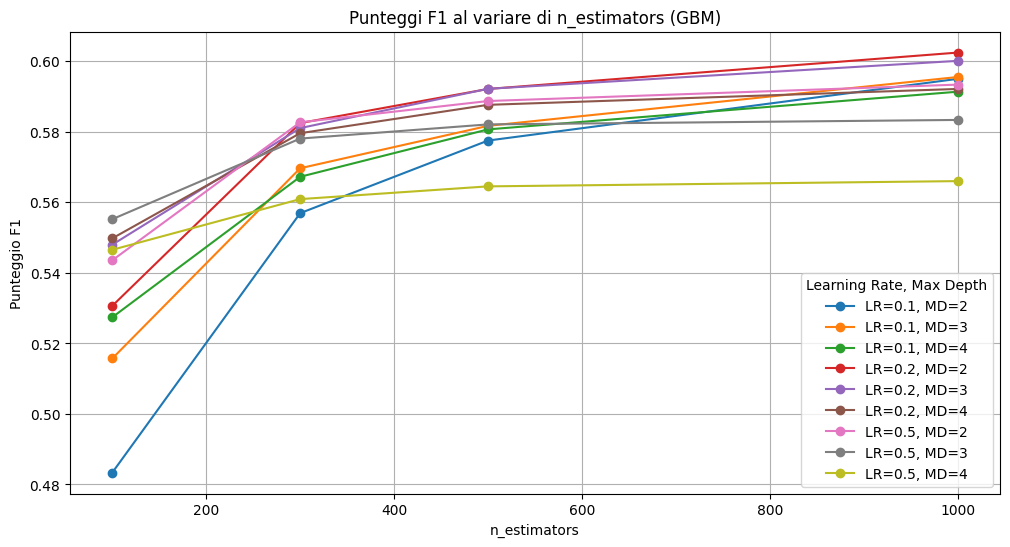

In [14]:
# Codifica le etichette
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Crea una griglia di valori di n_estimators, learning_rate e max_depth da provare
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.1, 0.2, 0.5],
    'max_depth': [2, 3, 4],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_micro', cv=5, n_jobs=-1)
# Addestra il modello con cross-validation
grid_search.fit(xtrain_svd, y_train_encoded)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
print("Migliori iperparametri:", grid_search.best_params_)

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Crea una griglia per i valori di n_estimators, learning_rate e max_depth
param_grid = grid_search.param_grid
n_estimators_values = param_grid['n_estimators']
learning_rate_values = param_grid['learning_rate']
max_depth_values = param_grid['max_depth']

plt.figure(figsize=(12, 6))

for learning_rate in learning_rate_values:
    for max_depth in max_depth_values:
        # Seleziona i punteggi per la combinazione specifica di learning_rate e max_depth
        mask = (grid_search.cv_results_['param_learning_rate'] == learning_rate) & (grid_search.cv_results_['param_max_depth'] == max_depth)
        n_estimators_scores = scores[mask]

        plt.plot(n_estimators_values, n_estimators_scores, marker='o', label=f'LR={learning_rate}, MD={max_depth}')

plt.title('Punteggi F1 al variare di n_estimators (GBM)')
plt.xlabel('n_estimators')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend(title='Learning Rate, Max Depth')
plt.show()


La profondità massima degli alberi, max_depth, è già minima, ovvero 2.

Quindi approfondiamo la ricerca sugli altri due iperparametri: Aumentiamo il numero degli stimatori, dal momento che precedentemente avevamo ottenuto il valore più alto tra quelli inseriti, e selezioniamo un intorno più piccolo di 0.2 per il paramentro learning_rate

Migliori iperparametri: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 2000}


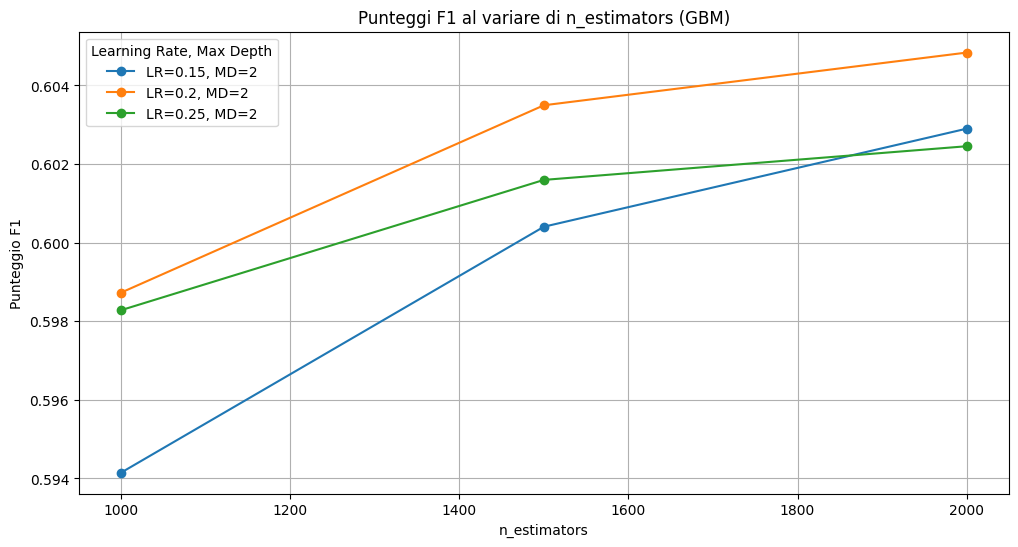

In [ ]:
# Codifica le etichette
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Crea una griglia di valori di n_estimators, learning_rate e max_depth da provare
param_grid = {
    'n_estimators': [1000, 1500, 2000],
    'learning_rate': [0.15, 0.2, 0.25],
    'max_depth': [2]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_micro', cv=5, n_jobs=-1)
# Addestra il modello con cross-validation
grid_search.fit(xtrain_svd, y_train_encoded)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
print("Migliori iperparametri:", grid_search.best_params_)

best_estimators = grid_search.best_params_['n_estimators']
best_learning_rate = grid_search.best_params_['learning_rate']
best_max_depth = grid_search.best_params_['max_depth']

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Crea una griglia per i valori di n_estimators, learning_rate e max_depth
param_grid = grid_search.param_grid
n_estimators_values = param_grid['n_estimators']
learning_rate_values = param_grid['learning_rate']
max_depth_values = param_grid['max_depth']

plt.figure(figsize=(12, 6))

for learning_rate in learning_rate_values:
    for max_depth in max_depth_values:
        # Seleziona i punteggi per la combinazione specifica di learning_rate e max_depth
        mask = (grid_search.cv_results_['param_learning_rate'] == learning_rate) & (grid_search.cv_results_['param_max_depth'] == max_depth)
        n_estimators_scores = scores[mask]

        plt.plot(n_estimators_values, n_estimators_scores, marker='o', label=f'LR={learning_rate}, MD={max_depth}')

plt.title('Punteggi F1 al variare di n_estimators (GBM)')
plt.xlabel('n_estimators')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend(title='Learning Rate, Max Depth')
plt.show()

Il valore del learning_rate rimane 0.2, mentre il numero di stimatori continua a crescere. Si potrebbe continuare ad aumentare n_estimators ma decidiamo di fermarci perchè 2000 stimatori sono già un numero fin troppo elevato.

Addestriamo il modello con i parametri trovati:

In [115]:
X_train,X_val,Y_train,Y_val = train_test_split(xtrain_svd, y_train, test_size=0.3)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, max_depth=2, n_estimators=2000, learning_rate=0.2)

Y_train_encoded = label_encoder.fit_transform(Y_train)

xgb_model.fit(X_train, Y_train_encoded)
y_pred = grid_search.best_estimator_.predict(X_val)
y_pred_original = label_encoder.inverse_transform(y_pred)

f1 = f1_score(Y_val, y_pred_original, average='micro')
BoW_NGrams_f1_scores.append(f1)
print("F1 Score Gradient Boosting:", f1)

F1 Score Gradient Boosting: 1.0


In [133]:
best_f1 = BoW_NGrams_f1_scores[0]
best_f1_logistic = BoW_NGrams_f1_scores[1]
best_f1_svm = BoW_NGrams_f1_scores[2]
best_f1_gb = BoW_NGrams_f1_scores[3]

best_row = pd.DataFrame({'Alpha': [best_alpha], 'F1 Score': [best_f1]})
best_row_logistic = pd.DataFrame({'C': [best_C], 'Penalty': [best_penalty], 'F1 Score': [best_f1_logistic]})
best_row_svm = pd.DataFrame({'C': [best_C_svm], 'Gamma': [best_gamma], 'F1 Score': [best_f1_svm]})
best_row_gb = pd.DataFrame({'n_estimators': [best_estimators], 'learning_rate': [best_learning_rate],
                            'max_depth': [best_max_depth], 'F1 Score': [best_f1_gb]})

display(HTML('<h2>Naive Bayes</h2>'))
display(HTML(best_row.to_html(index=False)))
display(HTML('<h2>Logistic Regression</h2>'))
display(HTML(best_row_logistic.to_html(index=False)))
display(HTML('<h2>Support Vector Machine</h2>'))
display(HTML(best_row_svm.to_html(index=False)))
display(HTML('<h2>Gradient Boosting</h2>'))
display(HTML(best_row_gb.to_html(index=False)))

Alpha,F1 Score
0.25,0.913605


C,Penalty,F1 Score
9,l2,0.976787


C,Gamma,F1 Score
95,0.001,0.930238


n_estimators,learning_rate,max_depth,F1 Score
2000,0.2,2,1.0


Il punteggio F1 più alto sul nostro dataset, dal quale abbiamo estratto i bigrammi e i trigrammi più frequenti, è ottenuto con il modello XGBoost(max_depth=2, n_estimators=2000, learning_rate=0.2) seguito dal LogisticRegression(C=9, penalty=l2)

## Stylistic Features
Le features stilistiche sono un insieme di caratteristiche o attributi estratti da un testo scritto al fine di analizzare e identificare gli stili di scrittura distintivi dell'autore. Queste features possono essere il numero di frasi in un pezzo di testo, il numero di parole in un pezzo di testo, numero medio di parole in una frase, lunghezza media delle parole in un pezzo di testo, numero di punti, numero di lettere maiuscole, e così via.

Tuttavia nel dataset fornito sono stati rimossi i segni di punteggiatura e le le lettere maiuscole, limitando la possibilità di estrarre alcune di queste features dai nostri testi. Abbiamo quindi estratto tre tipi di caratteristiche stilistiche: la lunghezza media delle parole, la ricchezza del vocabolario e la presenza di dialoghi nei testi.

In [76]:
def extract_features(text, author):
    # Calcolo della lunghezza media delle parole
    words = word_tokenize(text.lower())
    average_word_length = sum(len(word) for word in words) / len(words)

    # Calcolo della ricchezza del vocabolario
    vocabulary_richness = len(set(words)) / len(words)

    # Conteggio dei dialoghi ("said")
    dialogues_count = text.lower().count('said')

    return {
        'text': text,
        'author': author,  # Aggiungi l'autore alle caratteristiche
        'average_word_length': average_word_length,
        'vocabulary_richness': vocabulary_richness,
        'dialogues_count': dialogues_count,
    }

# Creazione del dataframe delle features
features_df = pd.DataFrame([extract_features(text, author) for text, author in zip(train_df['text'], train_df['author'])])

features_df.head(5)

,text,author,average_word_length,vocabulary_richness,dialogues_count
0,ou time listen give entire story said may form...,1,5.827506,0.832168,2
1,wish solitude twenty years age possession perf...,1,5.909474,0.781053,1
2,skirt blew perfect freedom upper parts wore ha...,1,5.620283,0.808962,1
3,san rows shops opposite impressed upon vision ...,1,5.659142,0.760722,7
4,hour walk tiresome three sensible english town...,1,5.638767,0.792952,2


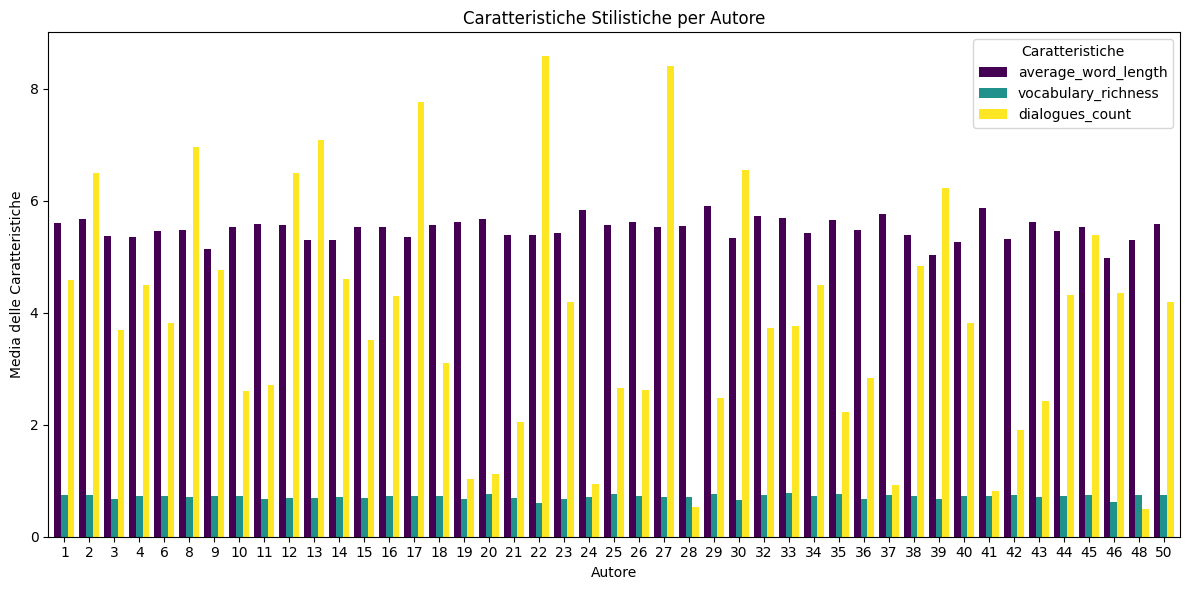

In [ ]:
grouped_df = features_df.drop('text', axis=1).groupby('author').mean()

grouped_df.plot(kind='bar', figsize=(12, 6), width=0.8, colormap='viridis')

plt.title('Caratteristiche Stilistiche per Autore')
plt.xlabel('Autore')
plt.ylabel('Media delle Caratteristiche')
plt.legend(title='Caratteristiche', loc='upper right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Inoltre abbiamo notato che alcuni degli autori hanno origini americane ad esempio James Baldwin e Washington Irving, perciò utilizziamo le differenze tra i termini inglesi e americani (come "theater", "color", "center"...) per distinguere gli autori americani e quelli inglesi.

In [77]:
american_words = [ 'theaters', 'humored','program', 'endeavoring', 'coloring', 'endeavored', 'honors', 'harbor', 'parlor', 'equaled', 'labors', 'quarreling', 'willful', 'fiber',
'splendor', 'worshiped', 'englishman','quarreled', 'behavior', 'fulfillment', 'catalog', 'honored', 'plow', 'recognize', 'favored', 'tranquility', 'neighboring', 'fulfill',
'endeavor', 'favorable', 'honorable', 'colors', 'learned', 'recognized', 'neighbors', 'neighbor', 'humor', 'mold', 'labor', 'favorite', 'neighborhood', 'colored', 'travelers',
'pretense', 'favor', 'ax', 'color', 'honor', 'gray', 'marvelous', 'traveler', 'practiced', 'theater', 'traveled', 'defense', 'offense', 'traveling', 'center']

english_words = set(words.words())

# Calcola la differenza tra parole americane e inglesi in un testo
def american_word_count(text):
    words = text.split()
    american_count = sum(1 for word in words if word in american_words)
    english_count = sum(1 for word in words if word in english_words)
    return american_count/english_count

# Aggiungi la caratteristica dell'indicatore di lingua ai DataFrame
features_df["american_word_diff"] = features_df["text"].apply(american_word_count)

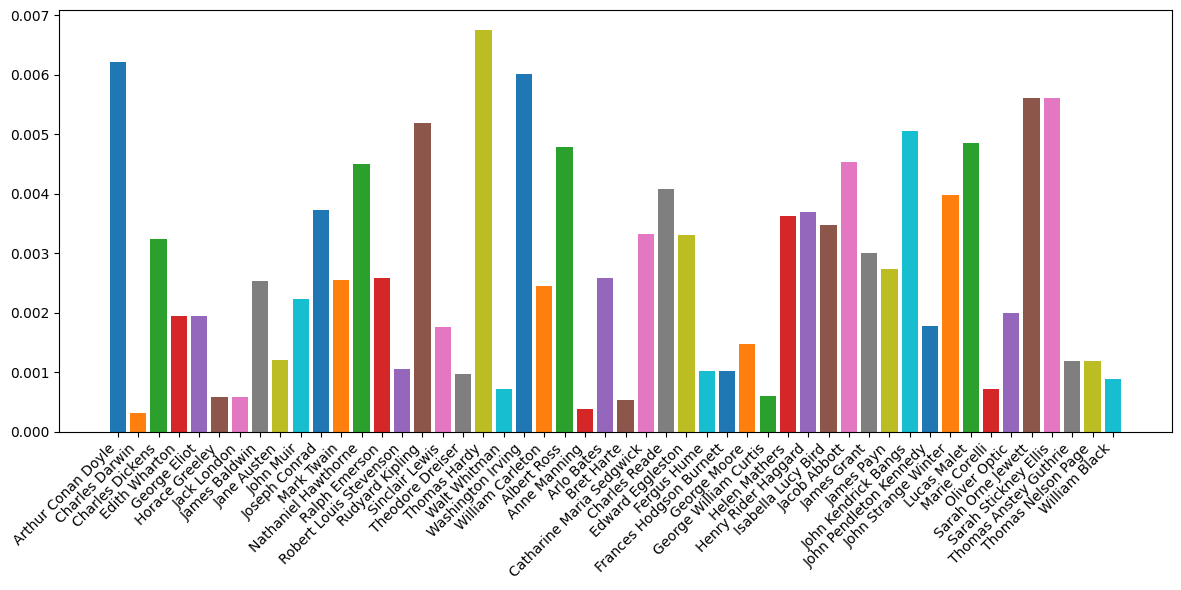

In [ ]:
# Creazione del grafico con etichette ruotate
plt.figure(figsize=(12, 6))
for index, author_name in enumerate(author_list, start=1):
    author_label = index  # L'etichetta dell'autore è l'indice numerico
    if author_label in features_df['author'].unique():
        mean_value = features_df[features_df.author == author_label]['american_word_diff'].mean()
    plt.bar(index, mean_value)

plt.xticks(range(1, len(author_list) + 1), author_list, rotation=45, ha='right')
plt.tight_layout()
plt.show()

Combiniamo le caratteristiche stilistiche estratte con i testi utilizzando hstack

In [78]:
features = ['text', 'average_word_length', 'vocabulary_richness', 'dialogues_count', 'american_word_diff']

# Inizializza lista di punteggi f1 con features stilometriche
BOW_Stylo_f1_scores = []

x_train = features_df[features]
ctv = CountVectorizer(max_features=10000)
# Vettorizza il testo di addestramento
x_train_ctv = ctv.fit_transform(x_train['text'])

y_train = train_df['author']

# Caratteristiche stilometriche
x_train_stylometric = csr_matrix(x_train.drop(columns=['text']), dtype=float)

# Combinazione delle caratteristiche
x_train = hstack([x_train_ctv, x_train_stylometric])

### Naive Bayes
Prima di effettuare la classficazione facciamo una ricerca sugli iperparametri del modello, in questo caso sul parametro "alpha" che rappresenta il valore di addizione costante  utilizzato per evitare che le probabilità condizionate diventino zero in presenza di determinati dati, per trovare il valore di alpha che massimizza le prestazioni del modello Naive Bayes sul nostro dataset.

Migliori iperparametri: {'alpha': 0.27}


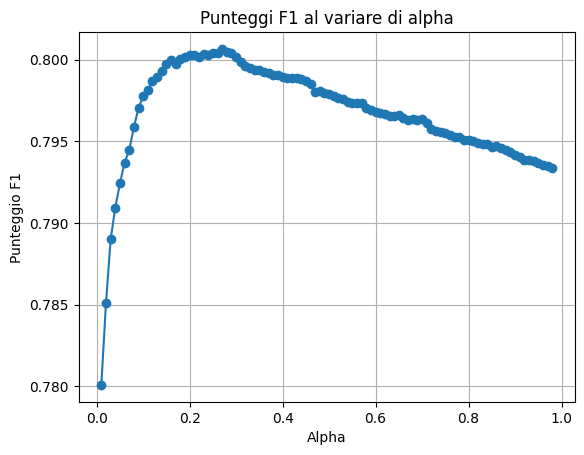

In [ ]:
# Crea una griglia di valori di alpha da provare
alpha_list=np.arange(start=0.01,stop=0.99,step=0.01)

param_grid = {
    'alpha': alpha_list
}

nb_model = MultinomialNB()

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, scoring='f1_micro', cv=5)
grid_search.fit(x_train, y_train)

print("Migliori iperparametri:", grid_search.best_params_)

best_alpha = grid_search.best_params_

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Plot dei punteggi F1 rispetto ai valori di alpha
plt.plot(alpha_list, scores, marker='o', linestyle='-')
plt.title('Punteggi F1 al variare di alpha')
plt.xlabel('Alpha')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.show()

Addestriamo il modello Naive Bayes con alpha = 0.27

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(x_train, y_train, test_size=0.3)

nb_model = MultinomialNB(alpha=0.27)
# Valuta il modello ottimizzato sui dati di test
nb_model.fit(X_train, Y_train)
nb_pred = nb_model.predict(X_val)
f1 = f1_score(Y_val, nb_pred, average='micro')
BOW_Stylo_f1_scores.append(f1)
print("F1 Score Multinomial Naive bayes:", f1)

F1 Score Multinomial Naive bayes: 0.9109980139026812


### Logistic Regression
Vogliamo trovare il miglior classificatore di regressione logistica sul nostro dataset, perciò effettuiamo una ricerca grid sui parametri "C" e "penalty", dove "C" determina quanto il modello è penalizzato per adattarsi troppo ai dati di addestramento e "penalty" determina il tipo di norma di regolarizzazione da applicare nella regressione logistica (l1 o l2).

In genere, i valori di C da provare includono una gamma di valori che coprono diverse scale di regolarizzazione.

Migliori iperparametri: {'C': 100, 'penalty': 'l2'}


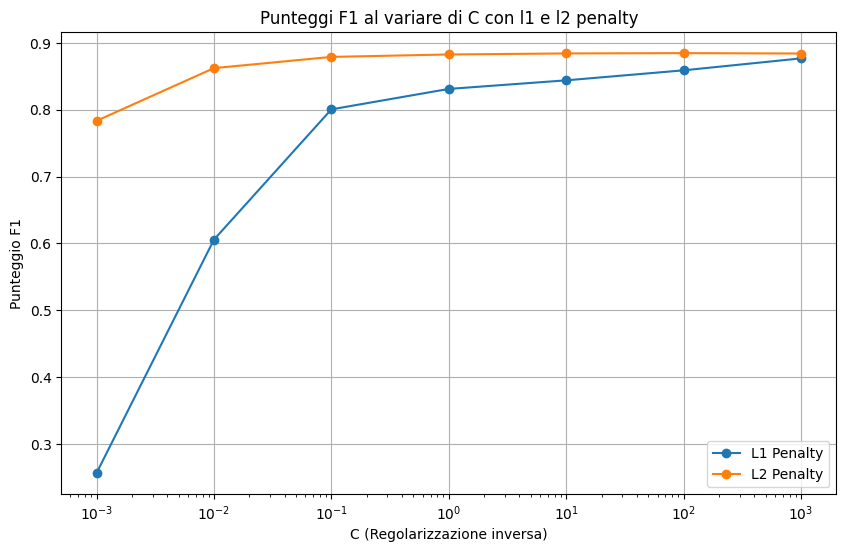

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # (regolarizzazione inversa)
    'penalty': ['l1','l2']          # Tipo di regolarizzazione
}

logistic_regression = LogisticRegression(solver='liblinear', max_iter=1000)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, scoring='f1_micro', cv=5)
grid_search.fit(x_train, y_train)

print("Migliori iperparametri:", grid_search.best_params_)

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']
param_range = param_grid['C']

l1_scores = scores[::2]  # Prendi i punteggi F1 per L1
l2_scores = scores[1::2]  # Prendi i punteggi F1 per L2

plt.figure(figsize=(10, 6))

# Plot dei punteggi F1 al variare di C
plt.plot(param_range, l1_scores, marker='o', linestyle='-', label='L1 Penalty')
plt.plot(param_range, l2_scores, marker='o', linestyle='-', label='L2 Penalty')

plt.title('Punteggi F1 al variare di C con l1 e l2 penalty')
plt.xlabel('C (Regolarizzazione inversa)')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.show()

Abbiamo effettuato una ricerca su diverse scale per l'iperparametro C e abbiamo visto che il modello si comporta meglio con un valore di C intorno al 100. Cerchiamo ora di trovare un valore più preciso eseguendo una ricerca grid su un intorno di 100

Migliori iperparametri: {'C': 150, 'penalty': 'l2'}


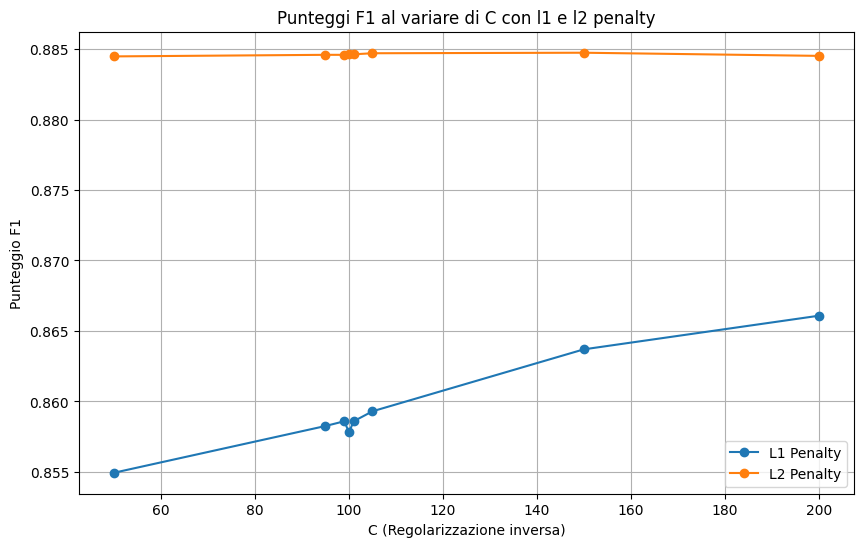

In [ ]:
# Crea una griglia di valori di C e penalty da provare
param_grid = {
    'C': [50, 95, 99, 100, 101, 105, 150, 200],  # (regolarizzazione inversa)
    'penalty': ['l1', 'l2']          # Tipo di regolarizzazione
}

logistic_regression = LogisticRegression(solver='liblinear', max_iter=1000)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, scoring='f1_micro', cv=5)
grid_search.fit(x_train, y_train)

print("Migliori iperparametri:", grid_search.best_params_)

best_C = grid_search.best_params_['C']
best_penalty = grid_search.best_params_['penalty']

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']
param_range = param_grid['C']

l1_scores = scores[::2]  # Prendi i punteggi F1 per L1
l2_scores = scores[1::2]

plt.figure(figsize=(10, 6))

# Plot dei punteggi F1 al variare di C
plt.plot(param_range, l1_scores, marker='o', linestyle='-', label='L1 Penalty')
plt.plot(param_range, l2_scores, marker='o', linestyle='-', label='L2 Penalty')

plt.title('Punteggi F1 al variare di C con l1 e l2 penalty')
plt.xlabel('C (Regolarizzazione inversa)')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend()
plt.show()

Dal grafico vediamo che F1 ha valori più alti tra C=100 e C=150, tuttavia la differenza è 100 e 150 è minima e non visibile sul grafico.
A questo punto addestriamo il modello con il parametro C=150 trovato con la ricerca grid.

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(x_train, y_train, test_size=0.3)

logistic_regression = LogisticRegression(solver='liblinear', max_iter=1000, C=150, penalty='l2')

logistic_regression.fit(X_train, Y_train)
# Valuta il modello ottimizzato sul validation set
lr_pred = logistic_regression.predict(X_val)
f1 = f1_score(Y_val, lr_pred, average='micro')
BOW_Stylo_f1_scores.append(f1)
print("F1 Score Logistic Regression:", f1)

F1 Score Logistic Regression: 0.9770368321747765


### Support Vector Machine
Effettuiamo l'analisi del gomito per individuare il numero di componenti dal quale il punteggio F1 cresce in modo meno significativo

Punto di Gomito: 300


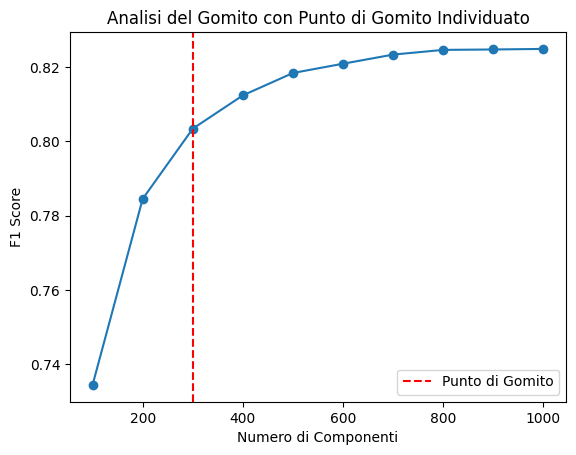

In [19]:
X_train,X_val,Y_train,Y_val = train_test_split(x_train, y_train, test_size=0.3)

components_range = np.arange(100, 1100, 100)

svm_model = SVC()

f1_scores = []

for n_components in components_range:
    svd = decomposition.TruncatedSVD(n_components=n_components)
    X_svd = svd.fit_transform(x_train)

    # Esegui la cross-validation con k=5
    cv_scores = cross_val_score(svm_model, X_svd, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1_micro')

    # Calcola la media dei punteggi F1 ottenuti durante ciascuna iterazione di cross-validation
    f1 = np.mean(cv_scores)
    f1_scores.append(f1)

# Trova il numero di componenti che massimizza il punteggio F1
best_n_components = components_range[np.argmax(f1_scores)]

# Utilizza KneeLocator per trovare il punto di gomito
kneedle = KneeLocator(components_range, f1_scores, curve='concave', direction='increasing')
elbow_point = kneedle.elbow

# Stampa il punto di gomito individuato
print(f"Punto di Gomito: {elbow_point}")

# Visualizza il grafico con il punto di gomito individuato
plt.plot(components_range, f1_scores, marker='o')
plt.xlabel('Numero di Componenti')
plt.ylabel('F1 Score')
plt.title('Analisi del Gomito con Punto di Gomito Individuato')
plt.axvline(x=elbow_point, color='r', linestyle='--', label='Punto di Gomito')
plt.legend()
plt.show()

Riduciamo la dimensioni del dataset a 300 componenti principali.

In [79]:
# Riduzione del dataset
svd = decomposition.TruncatedSVD(n_components=300)
svd.fit(x_train)
xtrain_svd = svd.transform(x_train)

# Normalizza i dati ottenuti da SVD
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)

Anche in questo caso effettuiamo una ricerca grid per trovare gli iperparametri "C" e "gamma" che massimizzano il modello Support Vector Machine sul nostro dataset.

Migliori iperparametri: {'C': 100, 'gamma': 0.001}


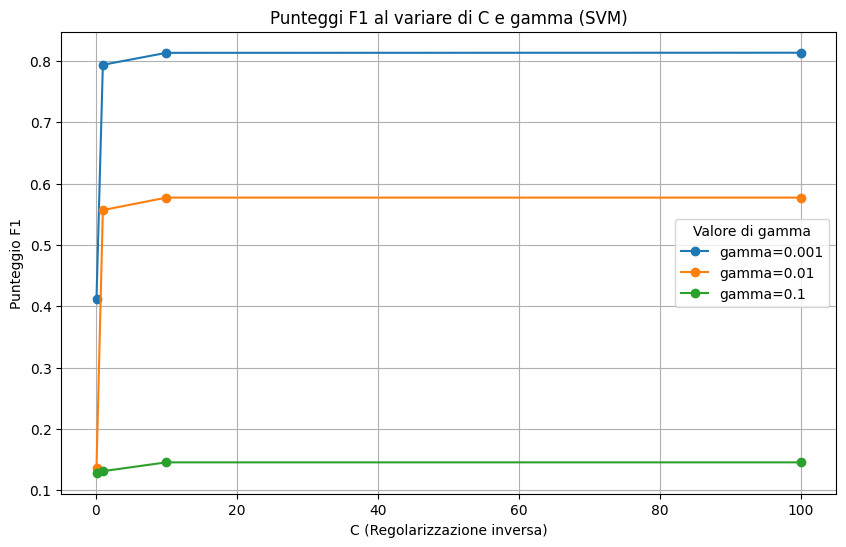

In [21]:
svm = SVC()

# Crea una griglia di valori di C e gamma da provare
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1]
}

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='f1_micro', cv=5)

# Addestra il modello con cross-validation
grid_search.fit(xtrain_svd_scl, y_train)

# Stampa i migliori iperparametri trovati
print("Migliori iperparametri:", grid_search.best_params_)

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Crea una griglia per i valori di C e gamma
param_grid = grid_search.param_grid
C_values = param_grid['C']
gamma_values = param_grid['gamma']

plt.figure(figsize=(10, 6))
for gamma_value in gamma_values:
    gamma_scores = scores[grid_search.cv_results_['param_gamma'] == gamma_value]
    plt.plot(C_values, gamma_scores, marker='o', label=f'gamma={gamma_value}')

plt.title('Punteggi F1 al variare di C e gamma (SVM)')
plt.xlabel('C (Regolarizzazione inversa)')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend(title='Valore di gamma')
plt.show()

Abbiamo ottenuto un valore di C più alto rispetto alle precedenti esecuzioni, che determina un adattamento maggiore ai dati di addestramento. Andiamo ora a rieseguire una ricerca grid su un intorno di 100 per il parametro C per ottenere valori più precisi.

Migliori iperparametri: {'C': 50, 'gamma': 0.001}


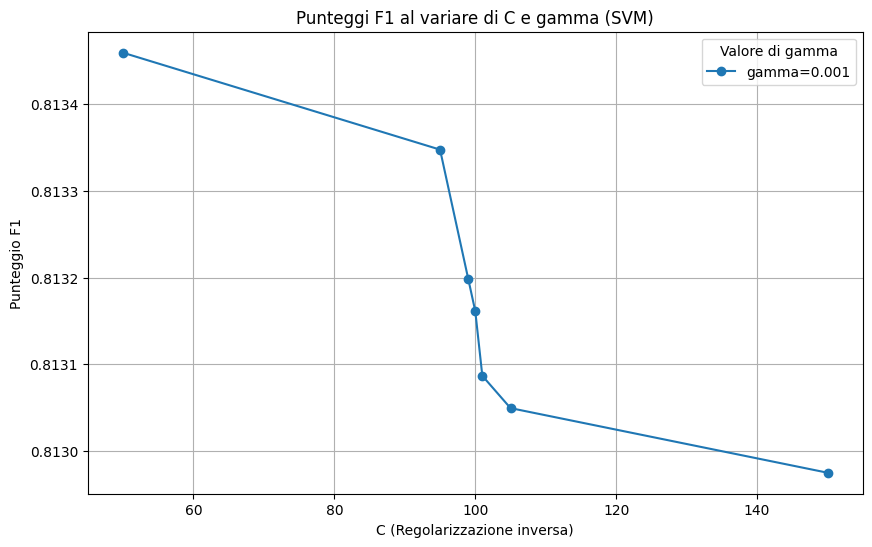

In [22]:
param_grid = {
    'C': [50, 95, 99, 100, 101, 105, 150],
    'gamma': [0.001]
}

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='f1_micro', cv=5)

# Addestra il modello con cross-validation
grid_search.fit(xtrain_svd_scl, y_train)

# Stampa i migliori iperparametri trovati
print("Migliori iperparametri:", grid_search.best_params_)

best_C_svm = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Crea una griglia per i valori di C e gamma
param_grid = grid_search.param_grid
C_values = param_grid['C']
gamma_values = param_grid['gamma']

plt.figure(figsize=(10, 6))
for gamma_value in gamma_values:
    gamma_scores = scores[grid_search.cv_results_['param_gamma'] == gamma_value]
    plt.plot(C_values, gamma_scores, marker='o', label=f'gamma={gamma_value}')

plt.title('Punteggi F1 al variare di C e gamma (SVM)')
plt.xlabel('C (Regolarizzazione inversa)')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend(title='Valore di gamma')
plt.show()

Dal grafico vediamo che il punteggio F1 rimane decresce da C=50 in poi.

In [23]:
X_train,X_val,Y_train,Y_val = train_test_split(xtrain_svd_scl, y_train, test_size=0.3)

svm = SVC(C=50, gamma=0.001)
svm.fit(X_train, Y_train)

# Valuta il modello ottimizzato sui dati di test
svm_pred = svm.predict(X_val)
f1 = f1_score(Y_val, svm_pred, average='micro')
BOW_Stylo_f1_scores.append(f1)
print("F1 Score Support Vector Machine:", f1)

F1 Score Support Vector Machine: 0.9302383316782522


### Gradient Boosting
Effettuiamo una ricerca grid sul numero di alberi da addestrare nel modello XGBoost ("n_estimators"), la massima profondità consentita per ciascun albero ("max_depth") e il "learning_rate" che controlla la quantità di contributo di ciascun albero al modello complessivo.

Migliori iperparametri: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 1000}


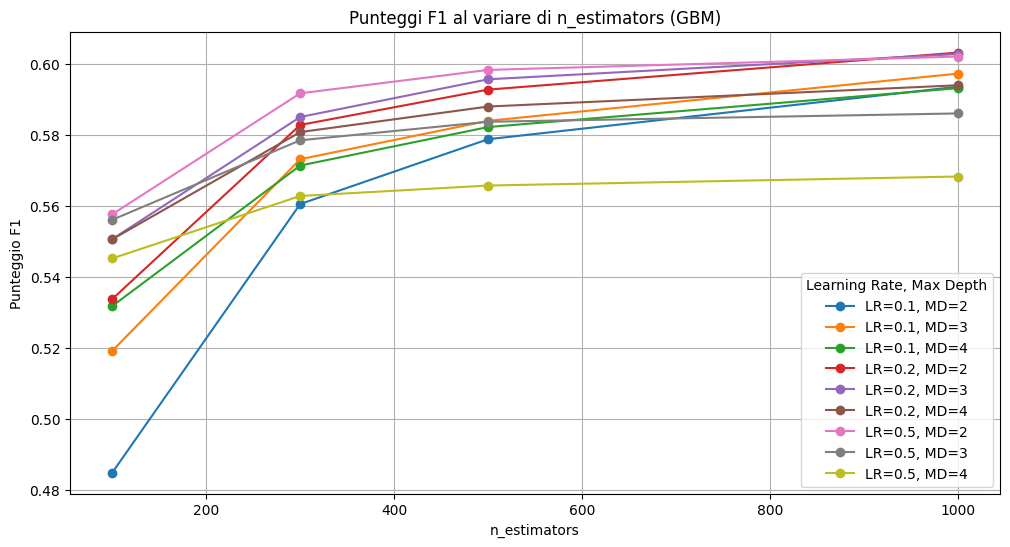

In [ ]:
# Codifica le etichette
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Crea una griglia di valori di n_estimators, learning_rate e max_depth da provare
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.1, 0.2, 0.5],
    'max_depth': [2, 3, 4],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_micro', cv=5, n_jobs=-1)
# Addestra il modello con cross-validation
grid_search.fit(xtrain_svd, y_train_encoded)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
print("Migliori iperparametri:", grid_search.best_params_)

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Crea una griglia per i valori di n_estimators, learning_rate e max_depth
param_grid = grid_search.param_grid
n_estimators_values = param_grid['n_estimators']
learning_rate_values = param_grid['learning_rate']
max_depth_values = param_grid['max_depth']

plt.figure(figsize=(12, 6))

for learning_rate in learning_rate_values:
    for max_depth in max_depth_values:
        # Seleziona i punteggi per la combinazione specifica di learning_rate e max_depth
        mask = (grid_search.cv_results_['param_learning_rate'] == learning_rate) & (grid_search.cv_results_['param_max_depth'] == max_depth)
        n_estimators_scores = scores[mask]

        plt.plot(n_estimators_values, n_estimators_scores, marker='o', label=f'LR={learning_rate}, MD={max_depth}')

plt.title('Punteggi F1 al variare di n_estimators (GBM)')
plt.xlabel('n_estimators')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend(title='Learning Rate, Max Depth')
plt.show()

La profondità massima degli alberi, max_depth, è già minima, ovvero 2.

Quindi approfondiamo la ricerca sugli altri due iperparametri: Aumentiamo il numero degli stimatori, dal momento che precedentemente avevamo ottenuto il valore più alto tra quelli inseriti, e selezioniamo un intorno più piccolo di 0.2 per il paramentro learning_rate

Migliori iperparametri: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 2000}


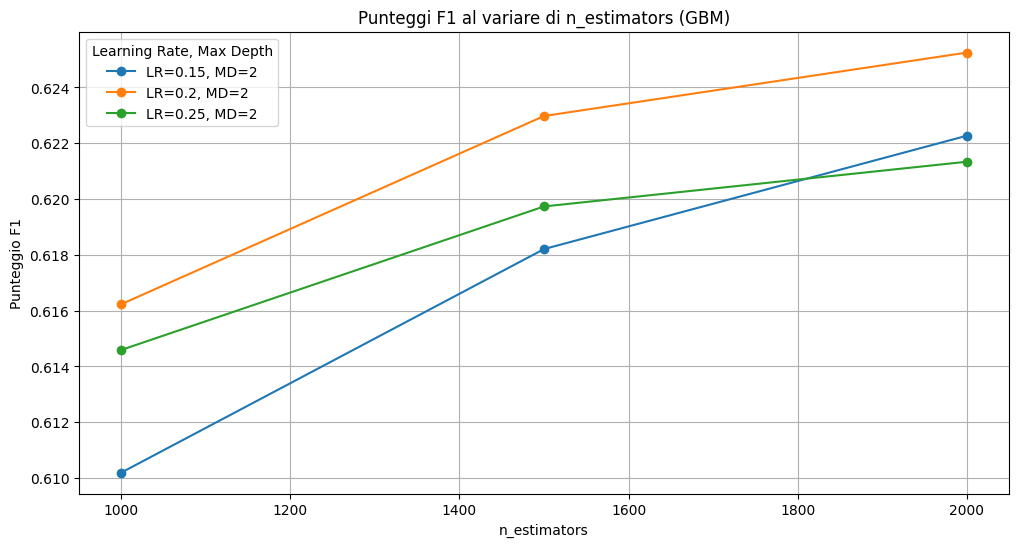

In [81]:
# Codifica le etichette
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Crea una griglia di valori di n_estimators, learning_rate e max_depth da provare
param_grid = {
    'n_estimators': [1000, 1500, 2000],
    'learning_rate': [0.15, 0.2, 0.25],
    'max_depth': [2]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_micro', cv=2, n_jobs=-1)
# Addestra il modello con cross-validation
grid_search.fit(xtrain_svd, y_train_encoded)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
print("Migliori iperparametri:", grid_search.best_params_)

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Crea una griglia per i valori di n_estimators, learning_rate e max_depth
param_grid = grid_search.param_grid
n_estimators_values = param_grid['n_estimators']
learning_rate_values = param_grid['learning_rate']
max_depth_values = param_grid['max_depth']

plt.figure(figsize=(12, 6))

for learning_rate in learning_rate_values:
    for max_depth in max_depth_values:
        # Seleziona i punteggi per la combinazione specifica di learning_rate e max_depth
        mask = (grid_search.cv_results_['param_learning_rate'] == learning_rate) & (grid_search.cv_results_['param_max_depth'] == max_depth)
        n_estimators_scores = scores[mask]

        plt.plot(n_estimators_values, n_estimators_scores, marker='o', label=f'LR={learning_rate}, MD={max_depth}')

plt.title('Punteggi F1 al variare di n_estimators (GBM)')
plt.xlabel('n_estimators')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend(title='Learning Rate, Max Depth')
plt.show()

Addestriamo ora il modello con iperparametri n_estimators=2000, learning_rate=0.2 e max_depth=2 e valutiamo sul validation set

In [83]:
X_train,X_val,Y_train,Y_val = train_test_split(xtrain_svd, y_train, test_size=0.3)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, max_depth=2, n_estimators=2000, learning_rate=0.2)

Y_train_encoded = label_encoder.fit_transform(Y_train)

xgb_model.fit(X_train, Y_train_encoded)
y_pred = grid_search.best_estimator_.predict(X_val)
y_pred_original = label_encoder.inverse_transform(y_pred)

f1 = f1_score(Y_val, y_pred_original, average='micro')
BOW_Stylo_f1_scores.append(f1)
print("F1 Score Gradient Boosting:", f1)

F1 Score Gradient Boosting: 1.0


In [82]:
best_f1 = BOW_Stylo_f1_scores[0]
best_f1_logistic = BOW_Stylo_f1_scores[1]
best_f1_svm = BOW_Stylo_f1_scores[2]
best_f1_gb = BOW_Stylo_f1_scores[3]

best_row = pd.DataFrame({'Alpha': [best_alpha], 'F1 Score': [best_f1]})
best_row_logistic = pd.DataFrame({'C': [best_C], 'Penalty': [best_penalty], 'F1 Score': [best_f1_logistic]})
best_row_svm = pd.DataFrame({'C': [best_C_svm], 'Gamma': [best_gamma], 'F1 Score': [best_f1_svm]})
best_row_gb = pd.DataFrame({'n_estimators': [best_estimators], 'learning_rate': [best_learning_rate],
                            'max_depth': [best_max_depth], 'F1 Score': [best_f1_gb]})

display(HTML('<h2>Naive Bayes</h2>'))
display(HTML(best_row.to_html(index=False)))
display(HTML('<h2>Logistic Regression</h2>'))
display(HTML(best_row_logistic.to_html(index=False)))
display(HTML('<h2>Support Vector Machine</h2>'))
display(HTML(best_row_svm.to_html(index=False)))
display(HTML('<h2>Gradient Boosting</h2>'))
display(HTML(best_row_gb.to_html(index=False)))

Alpha,F1 Score
0.27,0.910998


C,Penalty,F1 Score
150,l2,0.977036


C,Gamma,F1 Score
50,0.001,0.930238


n_estimators,learning_rate,max_depth,F1 Score
2000,0.2,2,1.0


Il punteggio F1 più alto sul nostro dataset è ottenuto con il modello XGBoost(max_depth=2, n_estimators=2000, learning_rate=0.3) seguito dal LogisticRegression(C=150, penalty=l2)

## Syntactic Analysis
L'analisi sintattica è una componente fondamentale nell'ambito dell'elaborazione del linguaggio naturale (NLP) e si riferisce al processo di analizzare la struttura grammaticale di una frase o di un testo al fine di determinare come le parole sono collegate tra loro. L'obiettivo dell'analisi sintattica è identificare le relazioni di dipendenza tra le parole e comprendere come queste parole contribuiscano alla costruzione del significato di una frase.

Di seguito utilizzeremo spaCy, una popolare libreria di elaborazione del linguaggio naturale (NLP) per eseguire l'analisi sintattica per l'individuazione delle relazioni di dipendenza tra le parole in una frase. Ecco alcune delle etichette  utilizzate da spaCy per identificare le relazioni di dipendenza:

- **NSUBJ**:  Soggetto nominale
- **DOBJ**:  Oggetto diretto
- **AMOD**:  Modificatore attributivo
- **ADVMOD**:  Modificatore avverbiale
- **PREP**:  Preposizione
- **CONJ**:  Congiunzione
- **ROOT**:  Radice della frase
- **AUX**:  Verbo ausiliario
- **CCOMP**: Complemento del verbo
- **DET**: Determinante

In [31]:
# Carica il modello spaCy
nlp = spacy.load("en_core_web_sm")


data = []
for testo in train_df['text']:
    doc = nlp(testo)

    relations = []
    for token in doc:
        # Verifica se il token ha un capo (head) nella relazione di dipendenza
        if token.head is not token:
            # Aggiunge le informazioni sulla relazione al dataset
            relations.append((token.text + " " + "(" + token.dep_.upper() + ")"))

    data.append({'Relazioni_di_Dipendenza': relations})

# Crea un DataFrame pandas con le features estratte
dataset = pd.DataFrame(data)
dataset['Relazioni_di_Dipendenza'] = dataset['Relazioni_di_Dipendenza'].apply(lambda x: ' '.join(x))
dataset.head(5)

,Relazioni_di_Dipendenza
0,ou (COMPOUND) time (NPADVMOD) listen (NSUBJ) g...
1,wish (CSUBJ) solitude (DOBJ) twenty (NUMMOD) y...
2,skirt (NSUBJ) blew (CCOMP) perfect (AMOD) free...
3,san (COMPOUND) rows (COMPOUND) shops (NSUBJ) o...
4,hour (COMPOUND) walk (NSUBJ) tiresome (NSUBJ) ...


Effetuiamo l'annotazione sintattica anche sul set di test

In [49]:
# Estrae entità nominate e crea un dataset
data = []
for testo in test_df['text']:
    doc = nlp(testo)

    relations = []
    for token in doc:
        # Verifica se il token ha un capo (head) nella relazione di dipendenza
        if token.head is not token:
            # Aggiunge le informazioni sulla relazione al dataset
            relations.append((token.text + " " + "(" + token.dep_.upper() + ")"))

    data.append({'Relazioni_di_Dipendenza': relations})

# Crea un DataFrame pandas con le features estratte
dataset_test = pd.DataFrame(data)
dataset_test['Relazioni_di_Dipendenza'] = dataset_test['Relazioni_di_Dipendenza'].apply(lambda x: ' '.join(x))

Addestriamo il modello con il dataset annotato

In [32]:
# Inizializza lista di punteggi f1 con relazioni di dipendenza
BOW_Syn_f1_scores = []

# Vettorizzazione BOW
ctv = CountVectorizer(max_features=10000)

x_train = ctv.fit_transform(dataset['Relazioni_di_Dipendenza'])

y_train = train_df['author']

### Naive Bayes
Prima di effettuare la classficazione facciamo una ricerca sugli iperparametri del modello, in questo caso sul parametro "alpha" che rappresenta il valore di addizione costante  utilizzato per evitare che le probabilità condizionate diventino zero in presenza di determinati dati, per trovare il valore di alpha che massimizza le prestazioni del modello Naive Bayes sul nostro dataset.

Migliori iperparametri: {'alpha': 0.28}


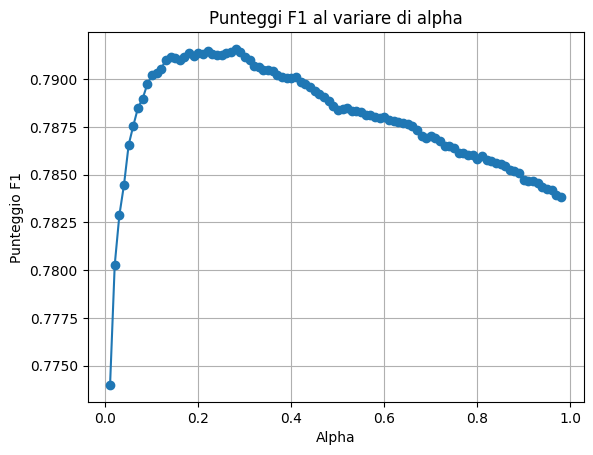

In [ ]:
# Crea una griglia di valori di alpha da provare
alpha_list=np.arange(start=0.01,stop=0.99,step=0.01)

param_grid = {
    'alpha': alpha_list
}

nb_model = MultinomialNB()

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, scoring='f1_micro', cv=5)
grid_search.fit(x_train, y_train)

print("Migliori iperparametri:", grid_search.best_params_)

best_alpha = grid_search.best_params_

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Plot dei punteggi F1 rispetto ai valori di alpha
plt.plot(alpha_list, scores, marker='o', linestyle='-')
plt.title('Punteggi F1 al variare di alpha')
plt.xlabel('Alpha')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.show()


Addestriamo il modello Naive Bayes con alpha = 0.28

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(x_train, y_train, test_size=0.3)

nb_model = MultinomialNB(alpha=0.28)
# Valuta il modello ottimizzato sui dati di test
nb_model.fit(X_train, Y_train)
nb_pred = nb_model.predict(X_val)
f1 = f1_score(Y_val, nb_pred, average='micro')
BOW_Syn_f1_scores.append(f1)
print("F1 Score Multinomial Naive bayes:", f1)


F1 Score Multinomial Naive bayes: 0.8969712015888779


### Logistic Regression
Vogliamo trovare il miglior classificatore di regressione logistica sul nostro dataset, perciò effettuiamo una ricerca grid sui parametri "C" e "penalty", dove "C" determina quanto il modello è penalizzato per adattarsi troppo ai dati di addestramento e "penalty" determina il tipo di norma di regolarizzazione da applicare nella regressione logistica (l1 o l2).

In genere, i valori di C da provare includono una gamma di valori che coprono diverse scale di regolarizzazione.

Migliori iperparametri: {'C': 1, 'penalty': 'l2'}


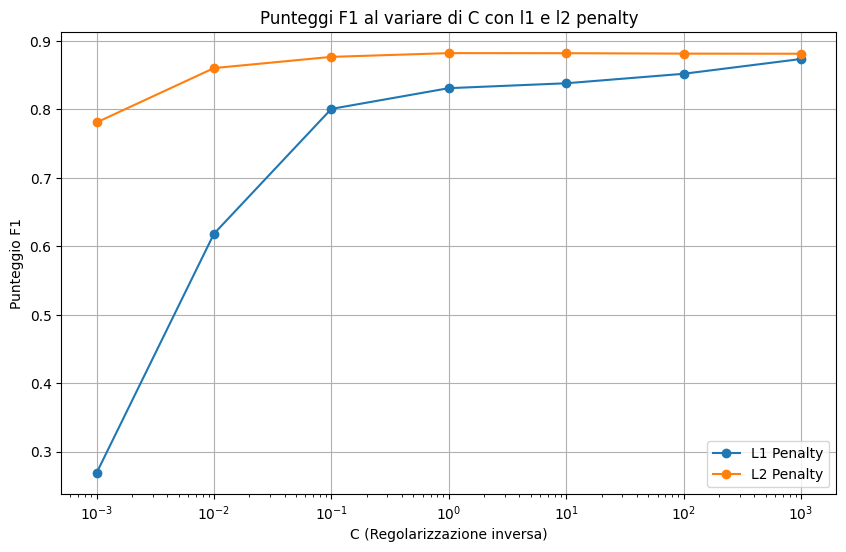

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # (regolarizzazione inversa)
    'penalty': ['l1','l2']          # Tipo di regolarizzazione
}

logistic_regression = LogisticRegression(solver='liblinear', max_iter=1000)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, scoring='f1_micro', cv=5)
grid_search.fit(x_train, y_train)

print("Migliori iperparametri:", grid_search.best_params_)

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']
param_range = param_grid['C']

l1_scores = scores[::2]  # Prendi i punteggi F1 per L1
l2_scores = scores[1::2]  # Prendi i punteggi F1 per L2

plt.figure(figsize=(10, 6))

# Plot dei punteggi F1 al variare di C
plt.plot(param_range, l1_scores, marker='o', linestyle='-', label='L1 Penalty')
plt.plot(param_range, l2_scores, marker='o', linestyle='-', label='L2 Penalty')

plt.title('Punteggi F1 al variare di C con l1 e l2 penalty')
plt.xlabel('C (Regolarizzazione inversa)')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.show()

Vediamo che in questo caso il modello si comporta meglio con una regolarizzazione più forte rispetto alle precedenti, cioè C=1. Vediamo ora come il modello si comporta in un intorno di 1.

Migliori iperparametri: {'C': 1, 'penalty': 'l2'}


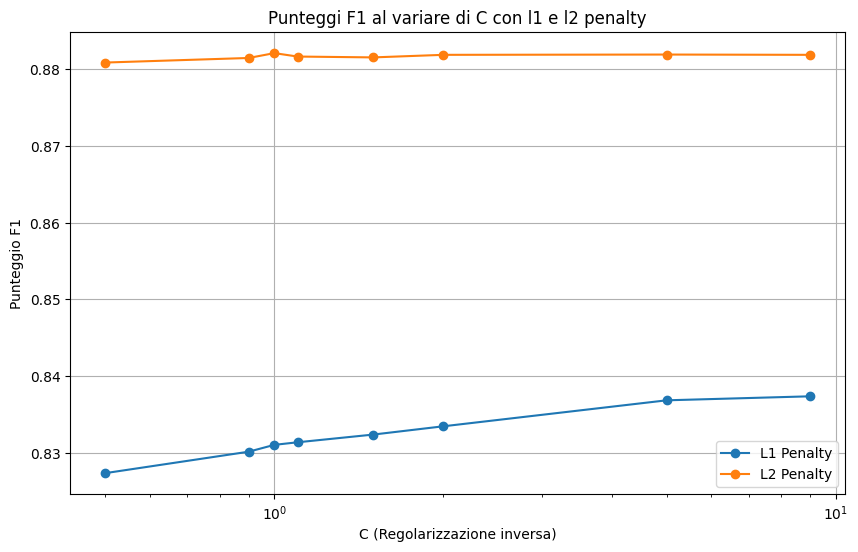

In [ ]:
param_grid = {
    'C': [0.5, 0.9, 1, 1.1, 1.5, 2, 5, 9],  # (regolarizzazione inversa)
    'penalty': ['l1','l2']          # Tipo di regolarizzazione
}

logistic_regression = LogisticRegression(solver='liblinear', max_iter=1000)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, scoring='f1_micro', cv=5)
grid_search.fit(x_train, y_train)

print("Migliori iperparametri:", grid_search.best_params_)

best_C = grid_search.best_params_['C']
best_penalty = grid_search.best_params_['penalty']

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']
param_range = param_grid['C']

l1_scores = scores[::2]  # Prendi i punteggi F1 per L1
l2_scores = scores[1::2]  # Prendi i punteggi F1 per L2

plt.figure(figsize=(10, 6))

# Plot dei punteggi F1 al variare di C
plt.plot(param_range, l1_scores, marker='o', linestyle='-', label='L1 Penalty')
plt.plot(param_range, l2_scores, marker='o', linestyle='-', label='L2 Penalty')

plt.title('Punteggi F1 al variare di C con l1 e l2 penalty')
plt.xlabel('C (Regolarizzazione inversa)')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.show()

Il valore migliore per l'iperparametro C è quindi 1.

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(x_train, y_train, test_size=0.3)

logistic_regression = LogisticRegression(solver='liblinear', max_iter=1000, C=1, penalty='l2')

logistic_regression.fit(X_train, Y_train)
# Valuta il modello ottimizzato sul validation set
lr_pred = logistic_regression.predict(X_val)
f1 = f1_score(Y_val, lr_pred, average='micro')
BOW_Syn_f1_scores.append(f1)
print("F1 Score Logistic Regression:", f1)

F1 Score Logistic Regression: 0.9774081429990069


### Support Vector Machine
Anche in questo caso cerchiamo il numero di componenti per la riduzione del dataset con l'analisi del ogmito e poi effettuiamo una ricerca grid per trovare gli iperparametri "C" e "gamma" che massimizzano il modello Support Vector Machine sul nostro dataset.

Punto di Gomito: 300


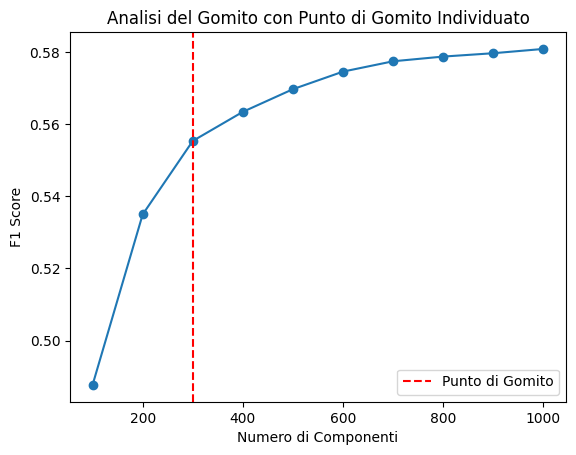

In [33]:
X_train,X_val,Y_train,Y_val = train_test_split(x_train, y_train, test_size=0.3)

components_range = np.arange(100, 1100, 100)

svm_model = SVC()

f1_scores = []

for n_components in components_range:
    svd = decomposition.TruncatedSVD(n_components=n_components)
    X_svd = svd.fit_transform(x_train)

    # Esegui la cross-validation con k=5
    cv_scores = cross_val_score(svm_model, X_svd, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1_micro')

    # Calcola la media dei punteggi F1 ottenuti durante ciascuna iterazione di cross-validation
    f1 = np.mean(cv_scores)
    f1_scores.append(f1)

# Trova il numero di componenti che massimizza il punteggio F1
best_n_components = components_range[np.argmax(f1_scores)]

# Utilizza KneeLocator per trovare il punto di gomito
kneedle = KneeLocator(components_range, f1_scores, curve='concave', direction='increasing')
elbow_point = kneedle.elbow

# Stampa il punto di gomito individuato
print(f"Punto di Gomito: {elbow_point}")

# Visualizza il grafico con il punto di gomito individuato
plt.plot(components_range, f1_scores, marker='o')
plt.xlabel('Numero di Componenti')
plt.ylabel('F1 Score')
plt.title('Analisi del Gomito con Punto di Gomito Individuato')
plt.axvline(x=elbow_point, color='r', linestyle='--', label='Punto di Gomito')
plt.legend()
plt.show()

In [34]:
# Riduzione del dataset
svd = decomposition.TruncatedSVD(n_components=300)
svd.fit(x_train)
xtrain_svd = svd.transform(x_train)

# Normalizza i dati ottenuti da SVD
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)

Migliori iperparametri: {'C': 10, 'gamma': 0.001}


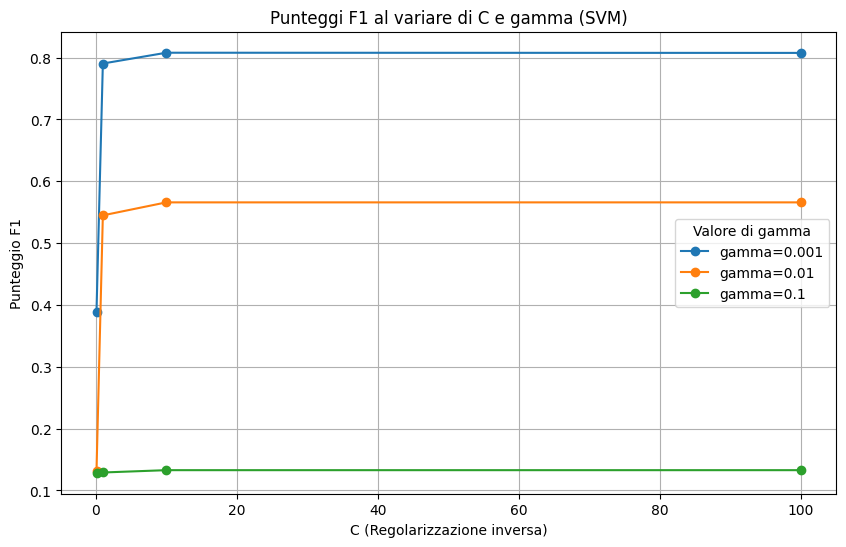

In [36]:
svm = SVC()

# Crea una griglia di valori di C e gamma da provare
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1]
}

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='f1_micro', cv=5)

# Addestra il modello con cross-validation
grid_search.fit(xtrain_svd_scl, y_train)

# Stampa i migliori iperparametri trovati
print("Migliori iperparametri:", grid_search.best_params_)

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Crea una griglia per i valori di C e gamma
param_grid = grid_search.param_grid
C_values = param_grid['C']
gamma_values = param_grid['gamma']

plt.figure(figsize=(10, 6))
for gamma_value in gamma_values:
    gamma_scores = scores[grid_search.cv_results_['param_gamma'] == gamma_value]
    plt.plot(C_values, gamma_scores, marker='o', label=f'gamma={gamma_value}')

plt.title('Punteggi F1 al variare di C e gamma (SVM)')
plt.xlabel('C (Regolarizzazione inversa)')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend(title='Valore di gamma')
plt.show()

Per affinare ancor di più la ricerca degli iperparmetri andiamo ora a rieseguire una ricerca grid su un intorno di 10 per il parametro C e su un intorno di 0.01 per il parametro gamma.

Migliori iperparametri: {'C': 5, 'gamma': 0.001}


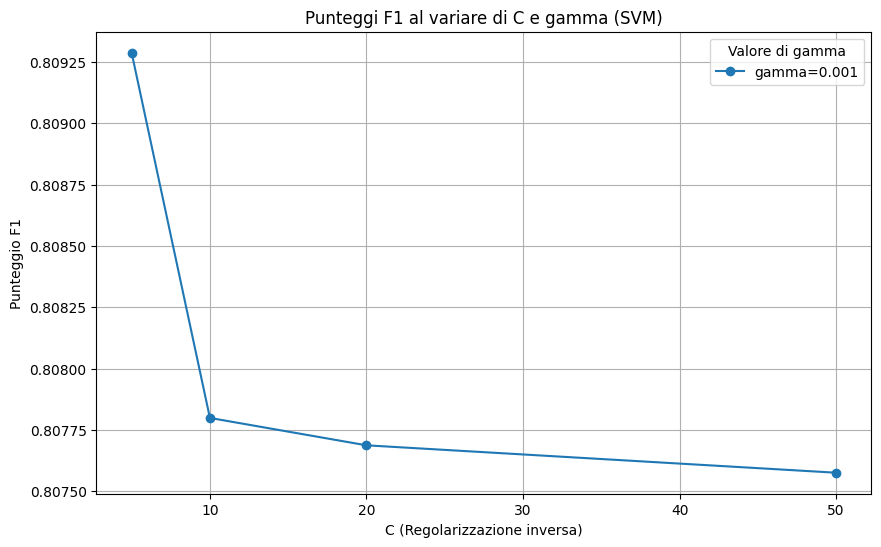

In [37]:
param_grid = {
    'C': [5, 10, 20, 50],
    'gamma': [0.001]
}

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='f1_micro', cv=5)

# Addestra il modello con cross-validation
grid_search.fit(xtrain_svd_scl, y_train)

# Stampa i migliori iperparametri trovati
print("Migliori iperparametri:", grid_search.best_params_)

best_C_svm = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Crea una griglia per i valori di C e gamma
param_grid = grid_search.param_grid
C_values = param_grid['C']
gamma_values = param_grid['gamma']

plt.figure(figsize=(10, 6))
for gamma_value in gamma_values:
    gamma_scores = scores[grid_search.cv_results_['param_gamma'] == gamma_value]
    plt.plot(C_values, gamma_scores, marker='o', label=f'gamma={gamma_value}')

plt.title('Punteggi F1 al variare di C e gamma (SVM)')
plt.xlabel('C (Regolarizzazione inversa)')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend(title='Valore di gamma')
plt.show()

Abbiamo trovato dei valori migliori per C e gamma, rispettivamente 5 e 0.005. Vediamo tuttavia che la differenza è minima perciò non ho ritenuto necessario raffinare ulteriormente la ricerca.

In [38]:
X_train,X_val,Y_train,Y_val = train_test_split(xtrain_svd_scl, y_train, test_size=0.3)

svm = SVC(C=5, gamma=0.001)
svm.fit(X_train, Y_train)

# Valuta il modello ottimizzato sui dati di test
svm_pred = svm.predict(X_val)
f1 = f1_score(Y_val, svm_pred, average='micro')
BOW_Syn_f1_scores.append(f1)
print("F1 Score Support Vector Machine:", f1)

F1 Score Support Vector Machine: 0.9208043694141013


### Gradient Boosting
Effettuiamo una ricerca grid sul numero di alberi da addestrare nel modello XGBoost ("n_estimators"), la massima profondità consentita per ciascun albero ("max_depth") e il "learning_rate" che controlla la quantità di contributo di ciascun albero al modello complessivo.

Migliori iperparametri: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 1000}


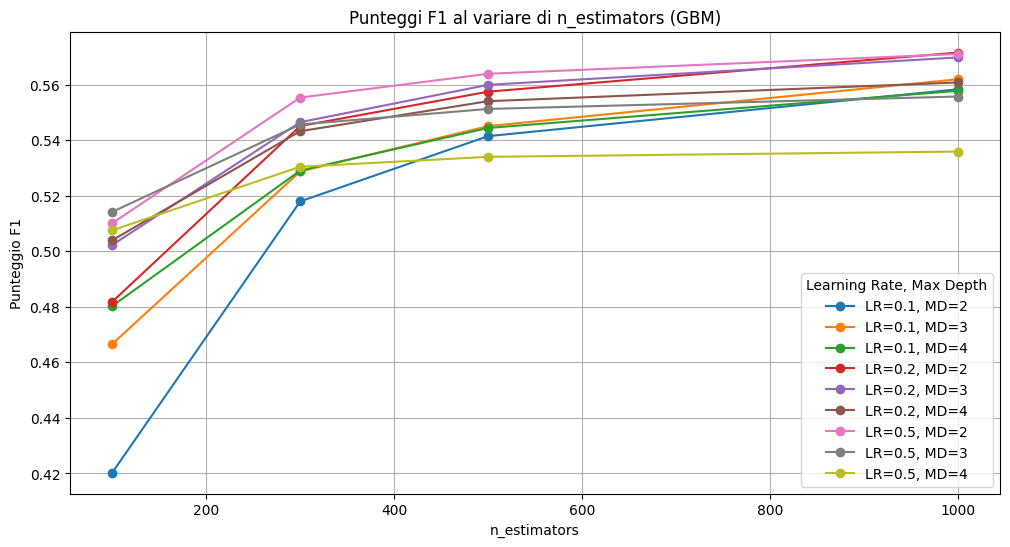

In [ ]:
# Codifica le etichette
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Crea una griglia di valori di n_estimators, learning_rate e max_depth da provare
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.1, 0.2, 0.5],
    'max_depth': [2, 3, 4],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_micro', cv=5, n_jobs=-1)
# Addestra il modello con cross-validation
grid_search.fit(xtrain_svd, y_train_encoded)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
print("Migliori iperparametri:", grid_search.best_params_)

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Crea una griglia per i valori di n_estimators, learning_rate e max_depth
param_grid = grid_search.param_grid
n_estimators_values = param_grid['n_estimators']
learning_rate_values = param_grid['learning_rate']
max_depth_values = param_grid['max_depth']

plt.figure(figsize=(12, 6))

for learning_rate in learning_rate_values:
    for max_depth in max_depth_values:
        # Seleziona i punteggi per la combinazione specifica di learning_rate e max_depth
        mask = (grid_search.cv_results_['param_learning_rate'] == learning_rate) & (grid_search.cv_results_['param_max_depth'] == max_depth)
        n_estimators_scores = scores[mask]

        plt.plot(n_estimators_values, n_estimators_scores, marker='o', label=f'LR={learning_rate}, MD={max_depth}')

plt.title('Punteggi F1 al variare di n_estimators (GBM)')
plt.xlabel('n_estimators')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend(title='Learning Rate, Max Depth')
plt.show()

La profondità massima degli alberi, max_depth, è già minima, ovvero 2.

Quindi approfondiamo la ricerca sugli altri due iperparametri: Aumentiamo il numero degli stimatori, dal momento che precedentemente avevamo ottenuto il valore più alto tra quelli inseriti, e selezioniamo un intorno più piccolo di 0.2 per il paramentro learning_rate

Migliori iperparametri: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 2000}


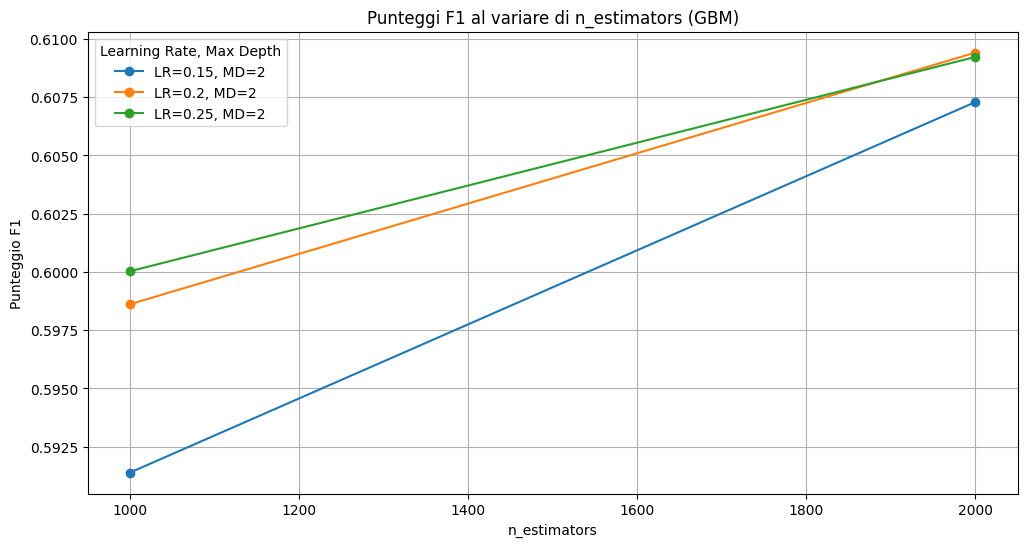

In [48]:
# Codifica le etichette
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Crea una griglia di valori di n_estimators, learning_rate e max_depth da provare
param_grid = {
    'n_estimators': [1000, 2000],
    'learning_rate': [0.15, 0.2, 0.25],
    'max_depth': [2]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_micro', cv=2, n_jobs=-1)
# Addestra il modello con cross-validation
grid_search.fit(xtrain_svd, y_train_encoded)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri con cross-validation
print("Migliori iperparametri:", grid_search.best_params_)

# Estrai i punteggi F1 dalla GridSearchCV
scores = grid_search.cv_results_['mean_test_score']

# Crea una griglia per i valori di n_estimators, learning_rate e max_depth
param_grid = grid_search.param_grid
n_estimators_values = param_grid['n_estimators']
learning_rate_values = param_grid['learning_rate']
max_depth_values = param_grid['max_depth']

plt.figure(figsize=(12, 6))

for learning_rate in learning_rate_values:
    for max_depth in max_depth_values:
        # Seleziona i punteggi per la combinazione specifica di learning_rate e max_depth
        mask = (grid_search.cv_results_['param_learning_rate'] == learning_rate) & (grid_search.cv_results_['param_max_depth'] == max_depth)
        n_estimators_scores = scores[mask]

        plt.plot(n_estimators_values, n_estimators_scores, marker='o', label=f'LR={learning_rate}, MD={max_depth}')

plt.title('Punteggi F1 al variare di n_estimators (GBM)')
plt.xlabel('n_estimators')
plt.ylabel('Punteggio F1')
plt.grid(True)
plt.legend(title='Learning Rate, Max Depth')
plt.show()

Abbiamo trovato un valore migliore per l'iperparametro learning_rate, addestriamo ora il modello con iperparametri n_estimators=2000, learning_rate=0.2 e max_depth=2 e valutiamo sul validation set

In [45]:
X_train,X_val,Y_train,Y_val = train_test_split(xtrain_svd, y_train, test_size=0.3)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, max_depth=2, n_estimators=2000, learning_rate=0.2)

Y_train_encoded = label_encoder.fit_transform(Y_train)

xgb_model.fit(X_train, Y_train_encoded)
y_pred = xgb_model.predict(X_val)
y_pred_original = label_encoder.inverse_transform(y_pred)

f1 = f1_score(Y_val, y_pred_original, average='micro')
BOW_Syn_f1_scores.append(f1)
print("F1 Score Gradient Boosting:", f1)

F1 Score Gradient Boosting: 0.8680486593843099


In [46]:
best_f1 = BOW_Syn_f1_scores[0]
best_f1_logistic = BOW_Syn_f1_scores[1]
best_f1_svm = BOW_Syn_f1_scores[2]
best_f1_gb = BOW_Syn_f1_scores[3]

best_row = pd.DataFrame({'Alpha': [best_alpha], 'F1 Score': [best_f1]})
best_row_logistic = pd.DataFrame({'C': [best_C], 'Penalty': [best_penalty], 'F1 Score': [best_f1_logistic]})
best_row_svm = pd.DataFrame({'C': [best_C_svm], 'Gamma': [best_gamma], 'F1 Score': [best_f1_svm]})
best_row_gb = pd.DataFrame({'n_estimators': [best_estimators], 'learning_rate': [best_learning_rate],
                            'max_depth': [best_max_depth], 'F1 Score': [best_f1_gb]})

display(HTML('<h2>Naive Bayes</h2>'))
display(HTML(best_row.to_html(index=False)))
display(HTML('<h2>Logistic Regression</h2>'))
display(HTML(best_row_logistic.to_html(index=False)))
display(HTML('<h2>Support Vector Machine</h2>'))
display(HTML(best_row_svm.to_html(index=False)))
display(HTML('<h2>Gradient Boosting</h2>'))
display(HTML(best_row_gb.to_html(index=False)))

Alpha,F1 Score
0.28,0.896971


C,Penalty,F1 Score
1,l2,0.977408


C,Gamma,F1 Score
5,0.001,0.920804


n_estimators,learning_rate,max_depth,F1 Score
2000,0.2,2,0.868049


Il punteggio F1 più alto sul nostro dataset annotato con le relazioni di dipendenza è ottenuto con il modello LogisticRegression(C=1, penalty=l2) seguito da SVM(C=5, gamma=0.001)

## Testing
Scegliamo i modelli che hanno ottenuto le prestazioni migliori sul validation set e andiamo a effettuare le previsioni sul test set, considerando sia il test set originale (contenente 50 autori) sia il test set ripulito, dal quale cioè abbiamo eliminato i 5 autori mancanti nel training set.

In generale abbiamo visto che il Logistic Regression e il Gradient Boosting sono i modelli si comportano meglio sul nostro dataset.

### Gradient Boosting (Bag of word with 2-grams e 3-grams)

F1 Score Gradient Boosting: 0.46199855625451164


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

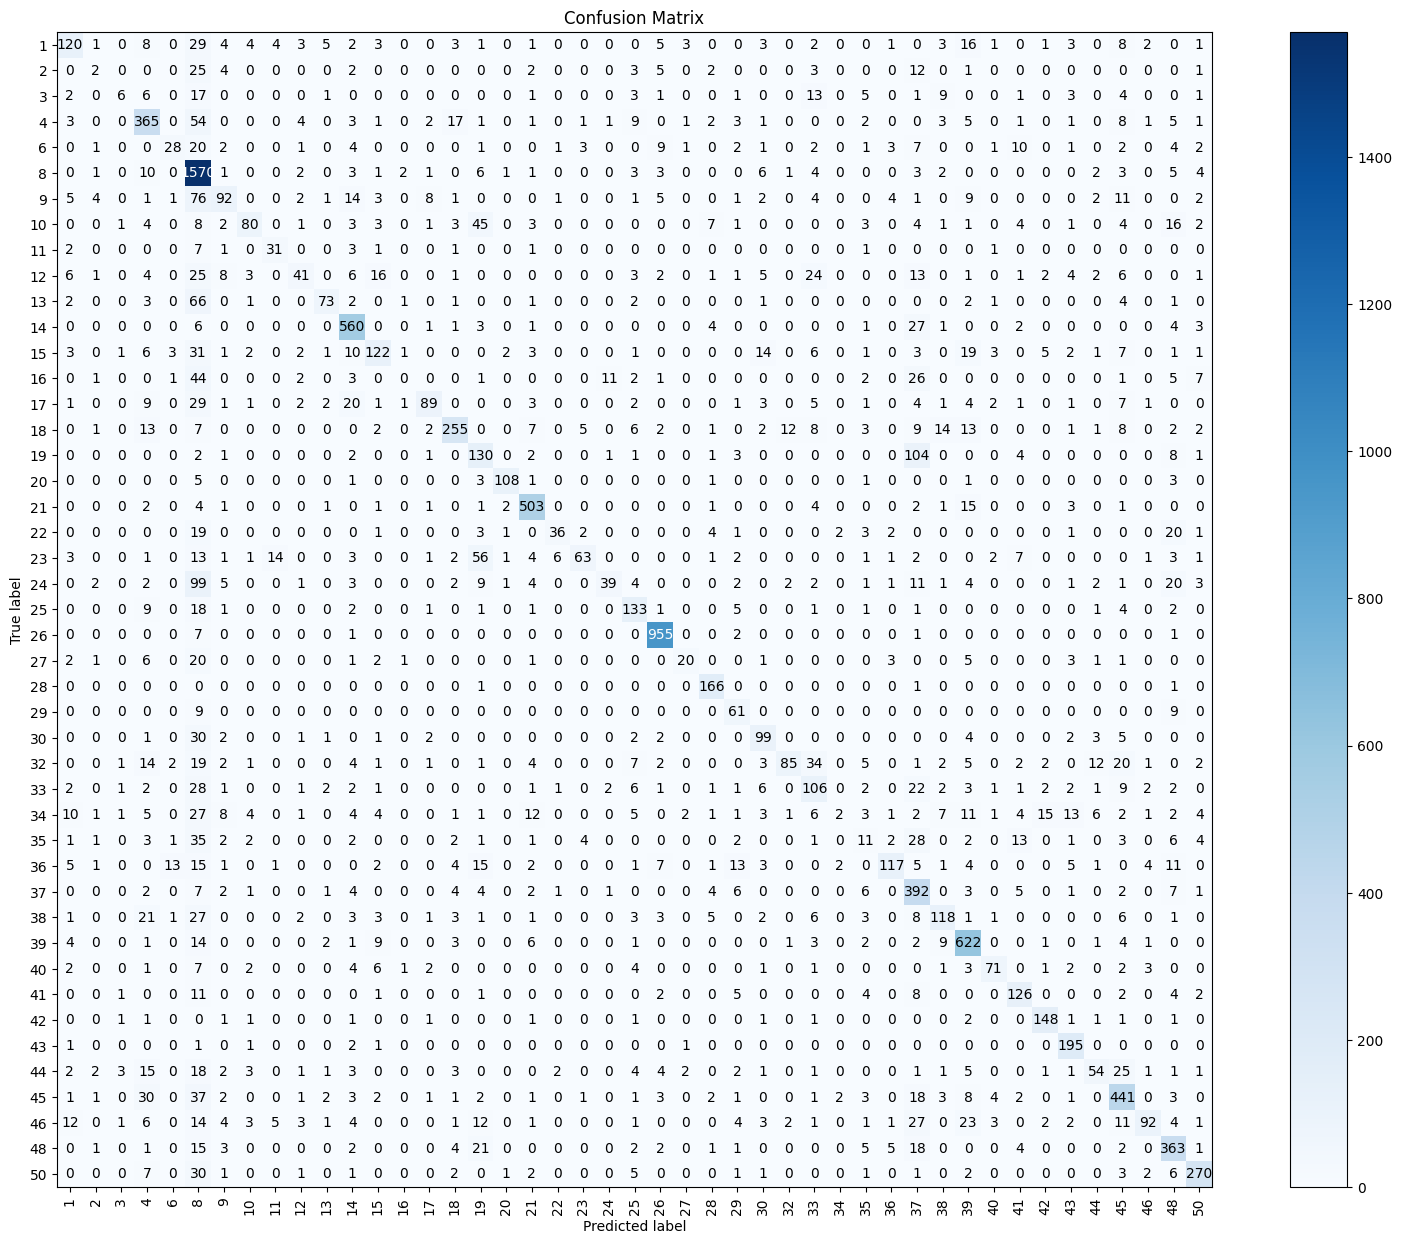

In [59]:
ctv = CountVectorizer(max_features=10000, ngram_range=(1, 3))

XGB_f1_scores = []

y_train = train_df['author'].values

x_train = ctv.fit_transform(train_df['text'])
x_test = ctv.transform(test_df['text'])

svd = decomposition.TruncatedSVD(n_components=300)
svd.fit(x_train)
xtrain_svd = svd.transform(x_train)
xtest_svd = svd.transform(x_test)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, max_depth=2, n_estimators=2000, learning_rate=0.2)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

xgb_model.fit(xtrain_svd, y_train_encoded)
y_pred = xgb_model.predict(xtest_svd)
y_pred_original = label_encoder.inverse_transform(y_pred)

f1 = f1_score(test_author, y_pred_original, average='micro')
XGB_f1_scores.append(f1)
print("F1 Score Gradient Boosting:", f1)

skplt.metrics.plot_confusion_matrix(
    test_author,
    y_pred_original,
    labels=train_df.author.unique(),
    x_tick_rotation=90,
    figsize=(20,15))

F1 Score Gradient Boosting: 0.6995627732667083


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

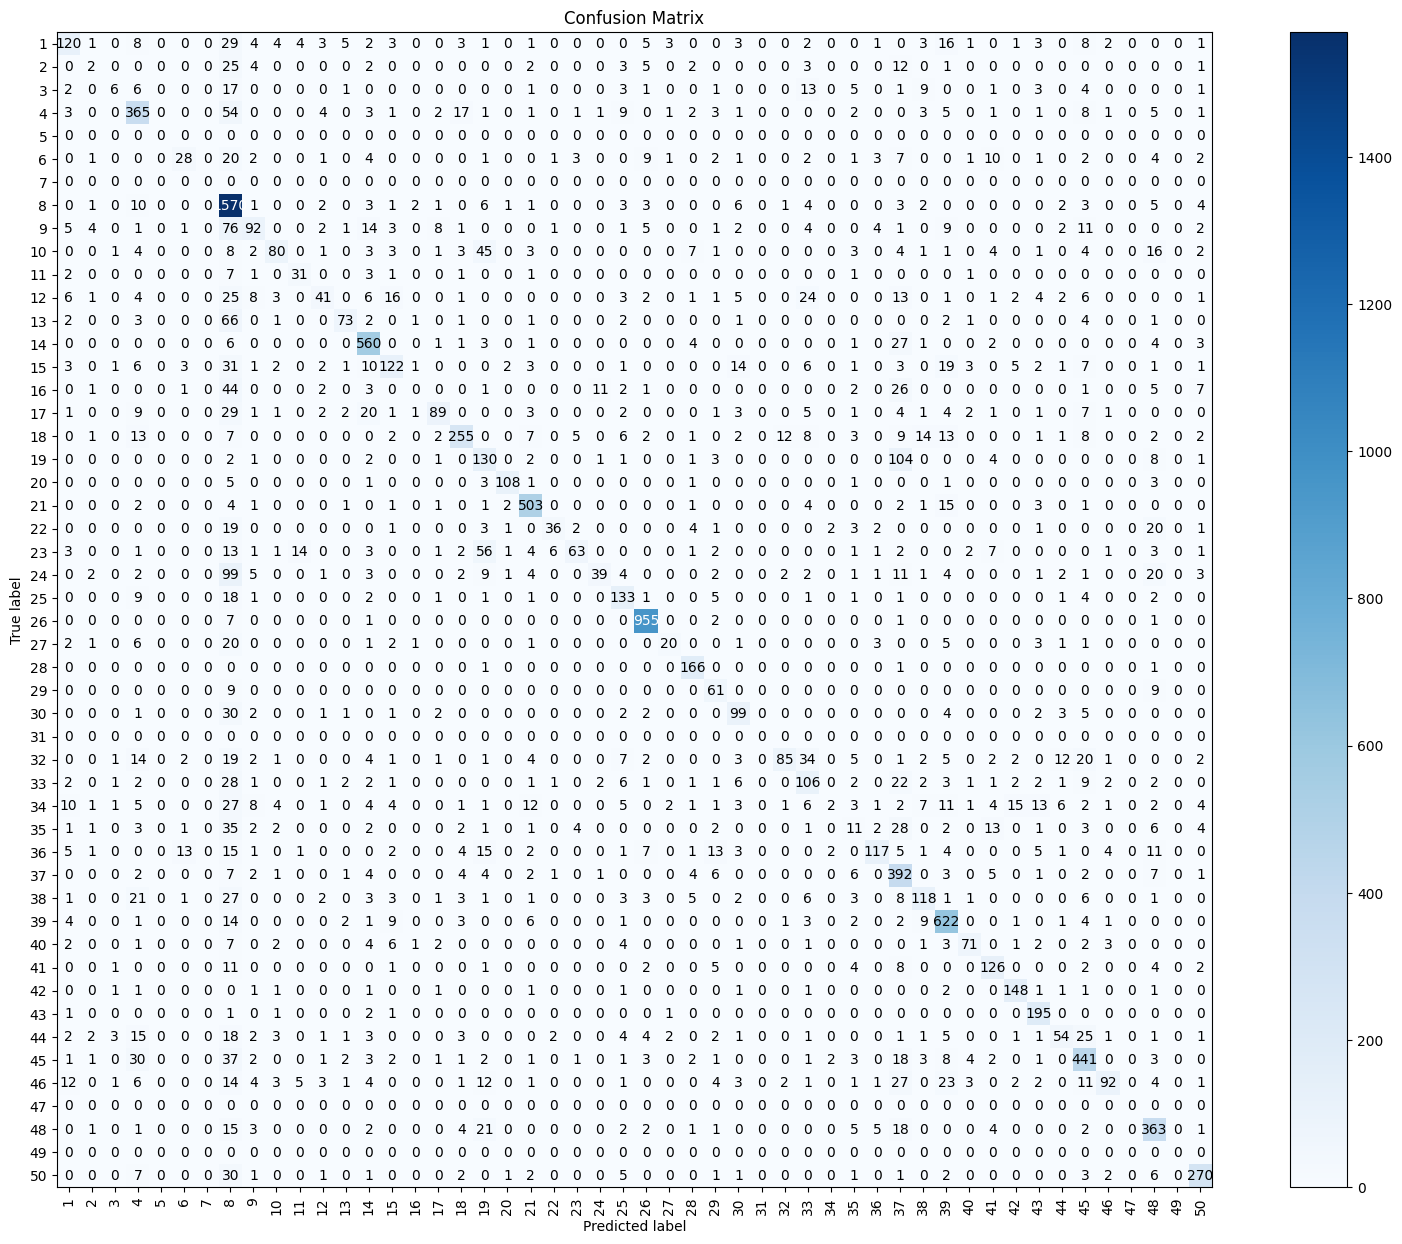

In [62]:
x_test = ctv.transform(new_test_df['text'])
xtest_svd = svd.transform(x_test)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, max_depth=2, n_estimators=2000, learning_rate=0.2)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

xgb_model.fit(xtrain_svd, y_train_encoded)
y_pred = xgb_model.predict(xtest_svd)
y_pred_original = label_encoder.inverse_transform(y_pred)

f1 = f1_score(new_test_author, y_pred_original, average='micro')
XGB_f1_scores.append(f1)
print("F1 Score Gradient Boosting:", f1)

skplt.metrics.plot_confusion_matrix(
    new_test_author,
    y_pred_original,
    labels=range(1, 51),
    x_tick_rotation=90,
    figsize=(20,15))

In [63]:
XGB_f1_scores_df = pd.DataFrame({'validation_set': [BoW_NGrams_f1_scores[3]],'test_df': [XGB_f1_scores[0]], 'new_test_df': [XGB_f1_scores[1]]})
display(HTML(XGB_f1_scores_df.to_html(index=False)))

validation_set,test_df,new_test_df
1.0,0.461999,0.699563


### Logistic Regression (Syntactic analysis)

F1 Score Logistic Regression: 0.5458904815922451


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

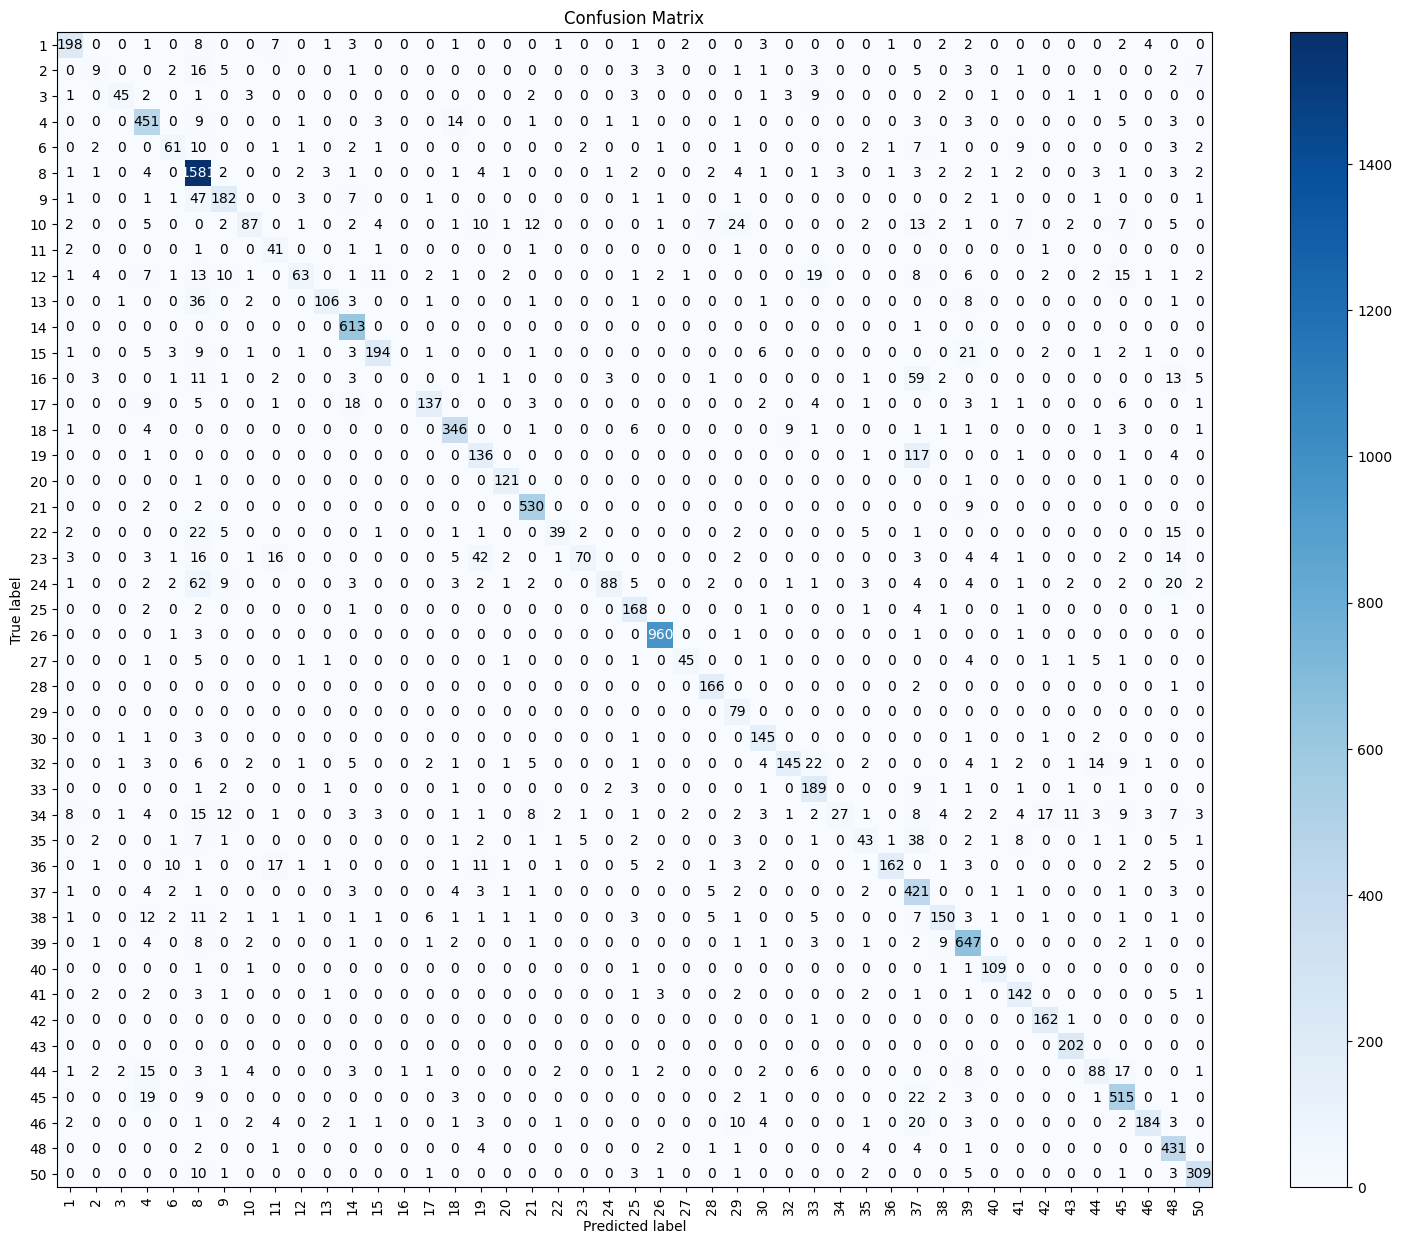

In [64]:
ctv = CountVectorizer(max_features=10000)

LR_f1_scores = []

x_train = ctv.fit_transform(dataset['Relazioni_di_Dipendenza'])
x_test = ctv.transform(dataset_test['Relazioni_di_Dipendenza'])

logistic_regression = LogisticRegression(solver='liblinear', max_iter=1000, C=1, penalty='l2')

logistic_regression.fit(x_train, y_train)
lr_pred = logistic_regression.predict(x_test)
f1 = f1_score(test_author, lr_pred, average='micro')
LR_f1_scores.append(f1)
print("F1 Score Logistic Regression:", f1)


skplt.metrics.plot_confusion_matrix(
    test_author,
    lr_pred,
    labels=train_df.author.unique(),
    x_tick_rotation=90,
    figsize=(20,15))

In [52]:
# Estrae entità nominate e crea un dataset
data = []
for testo in new_test_df['text']:
    doc = nlp(testo)

    relations = []
    for token in doc:
        # Verifica se il token ha un capo (head) nella relazione di dipendenza
        if token.head is not token:
            # Aggiunge le informazioni sulla relazione al dataset
            relations.append((token.text + " " + "(" + token.dep_.upper() + ")"))

    data.append({'Relazioni_di_Dipendenza': relations})

# Crea un DataFrame pandas con le features estratte
new_dataset_test = pd.DataFrame(data)
new_dataset_test['Relazioni_di_Dipendenza'] = new_dataset_test['Relazioni_di_Dipendenza'].apply(lambda x: ' '.join(x))

F1 Score Logistic Regression: 0.8265927545284197


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

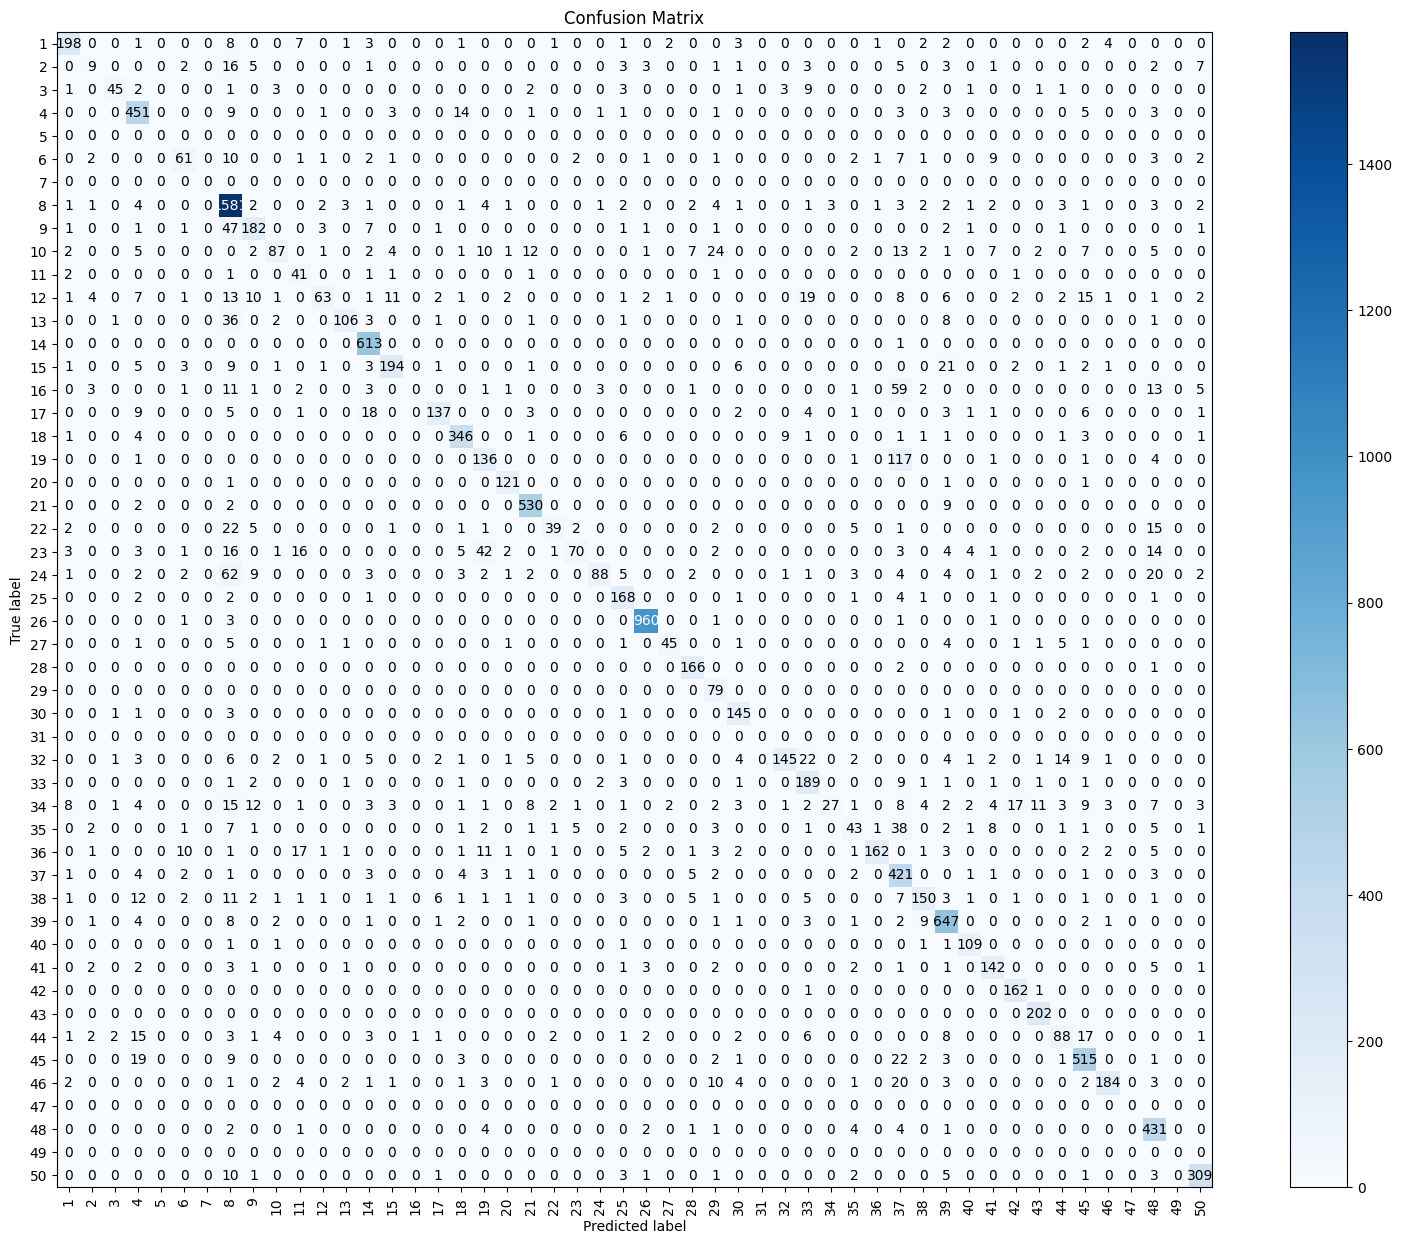

In [68]:
x_test = ctv.transform(new_dataset_test['Relazioni_di_Dipendenza'])

logistic_regression = LogisticRegression(solver='liblinear', max_iter=1000, C=1, penalty='l2')

logistic_regression.fit(x_train, y_train)
lr_pred = logistic_regression.predict(x_test)
f1 = f1_score(new_test_author, lr_pred, average='micro')
LR_f1_scores.append(f1)
print("F1 Score Logistic Regression:", f1)

skplt.metrics.plot_confusion_matrix(
    new_test_author,
    lr_pred,
    labels=range(1, 51),
    x_tick_rotation=90,
    figsize=(20,15))

In [69]:
LR_f1_scores_df = pd.DataFrame({'validation_set': [BOW_Syn_f1_scores[1]],'test_df': [LR_f1_scores[0]], 'new_test_df': [LR_f1_scores[1]]})
display(HTML(LR_f1_scores_df.to_html(index=False)))

validation_set,test_df,new_test_df
0.977408,0.54589,0.826593


### Gradient Boosting (Stylistic features)

In [84]:
def extract_features(text):
    # Calcolo della lunghezza media delle parole
    words = word_tokenize(text.lower())
    average_word_length = sum(len(word) for word in words) / len(words)

    # Calcolo della ricchezza del vocabolario
    vocabulary_richness = len(set(words)) / len(words)

    # Conteggio dei dialoghi ("said")
    dialogues_count = text.lower().count('said')

    return {
        'text': text,
        'average_word_length': average_word_length,
        'vocabulary_richness': vocabulary_richness,
        'dialogues_count': dialogues_count,
    }

# Creazione del dataframe delle features
features_test_df = pd.DataFrame([extract_features(text) for text in test_df['text']])


F1 Score Gradient Boosting: 0.5022171805713107


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

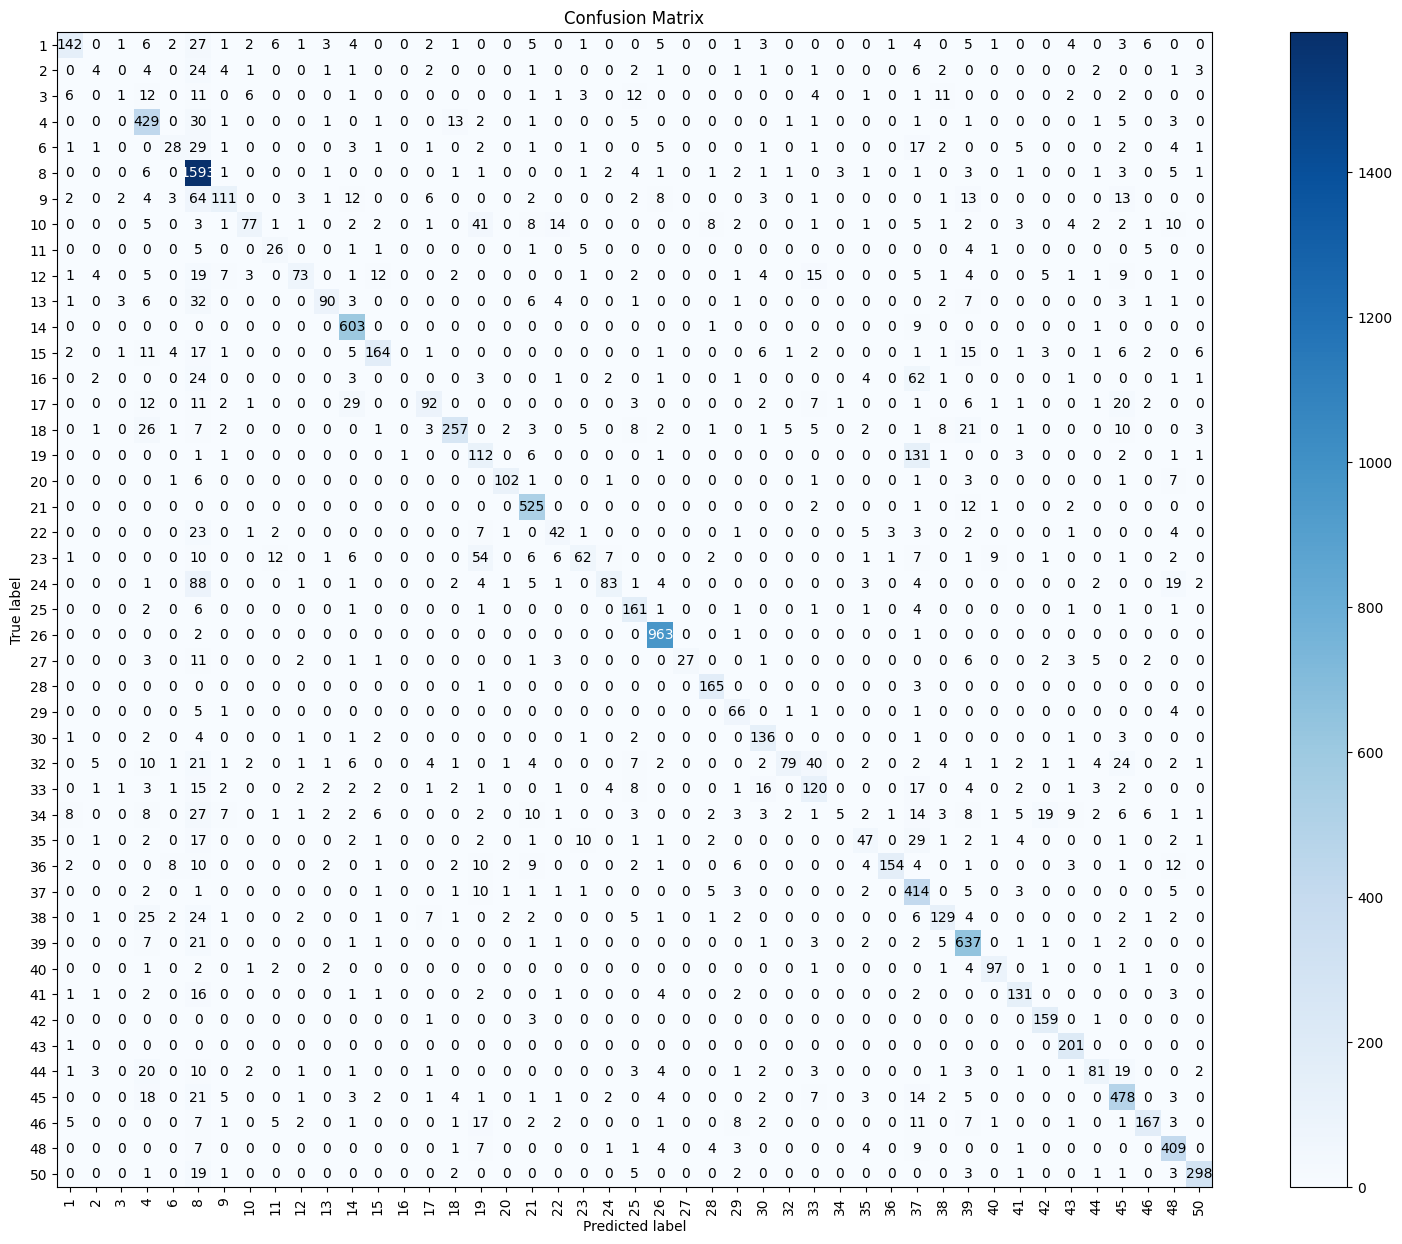

In [86]:
features_test_df["american_word_diff"] = features_test_df["text"].apply(american_word_count)

features = ['text', 'average_word_length', 'vocabulary_richness', 'dialogues_count', 'american_word_diff']
x_train = features_df[features]
x_test = features_test_df[features]

ctv = CountVectorizer(max_features=10000)

XGB_f1_scores = []

# Vettorizza il testo di addestramento
x_train_ctv = ctv.fit_transform(x_train['text'])
x_test_ctv = ctv.fit_transform(x_test['text'])

y_train = train_df['author']

# Caratteristiche stilometriche
x_train_stylometric = csr_matrix(x_train.drop(columns=['text']), dtype=float)
x_test_stylometric = csr_matrix(x_test.drop(columns=['text']), dtype=float)

# Combinazione delle caratteristiche
x_train = hstack([x_train_ctv, x_train_stylometric])
x_test = hstack([x_test_ctv, x_test_stylometric])

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, max_depth=2, n_estimators=2000, learning_rate=0.25)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

xgb_model.fit(x_train, y_train_encoded)
y_pred = xgb_model.predict(x_test)
y_pred_original = label_encoder.inverse_transform(y_pred)

f1 = f1_score(test_author, y_pred_original, average='micro')
XGB_f1_scores.append(f1)
print("F1 Score Gradient Boosting:", f1)

skplt.metrics.plot_confusion_matrix(
    test_author,
    y_pred_original,
    labels=train_df.author.unique(),
    x_tick_rotation=90,
    figsize=(20,15))

F1 Score Gradient Boosting: 0.7604622111180512


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

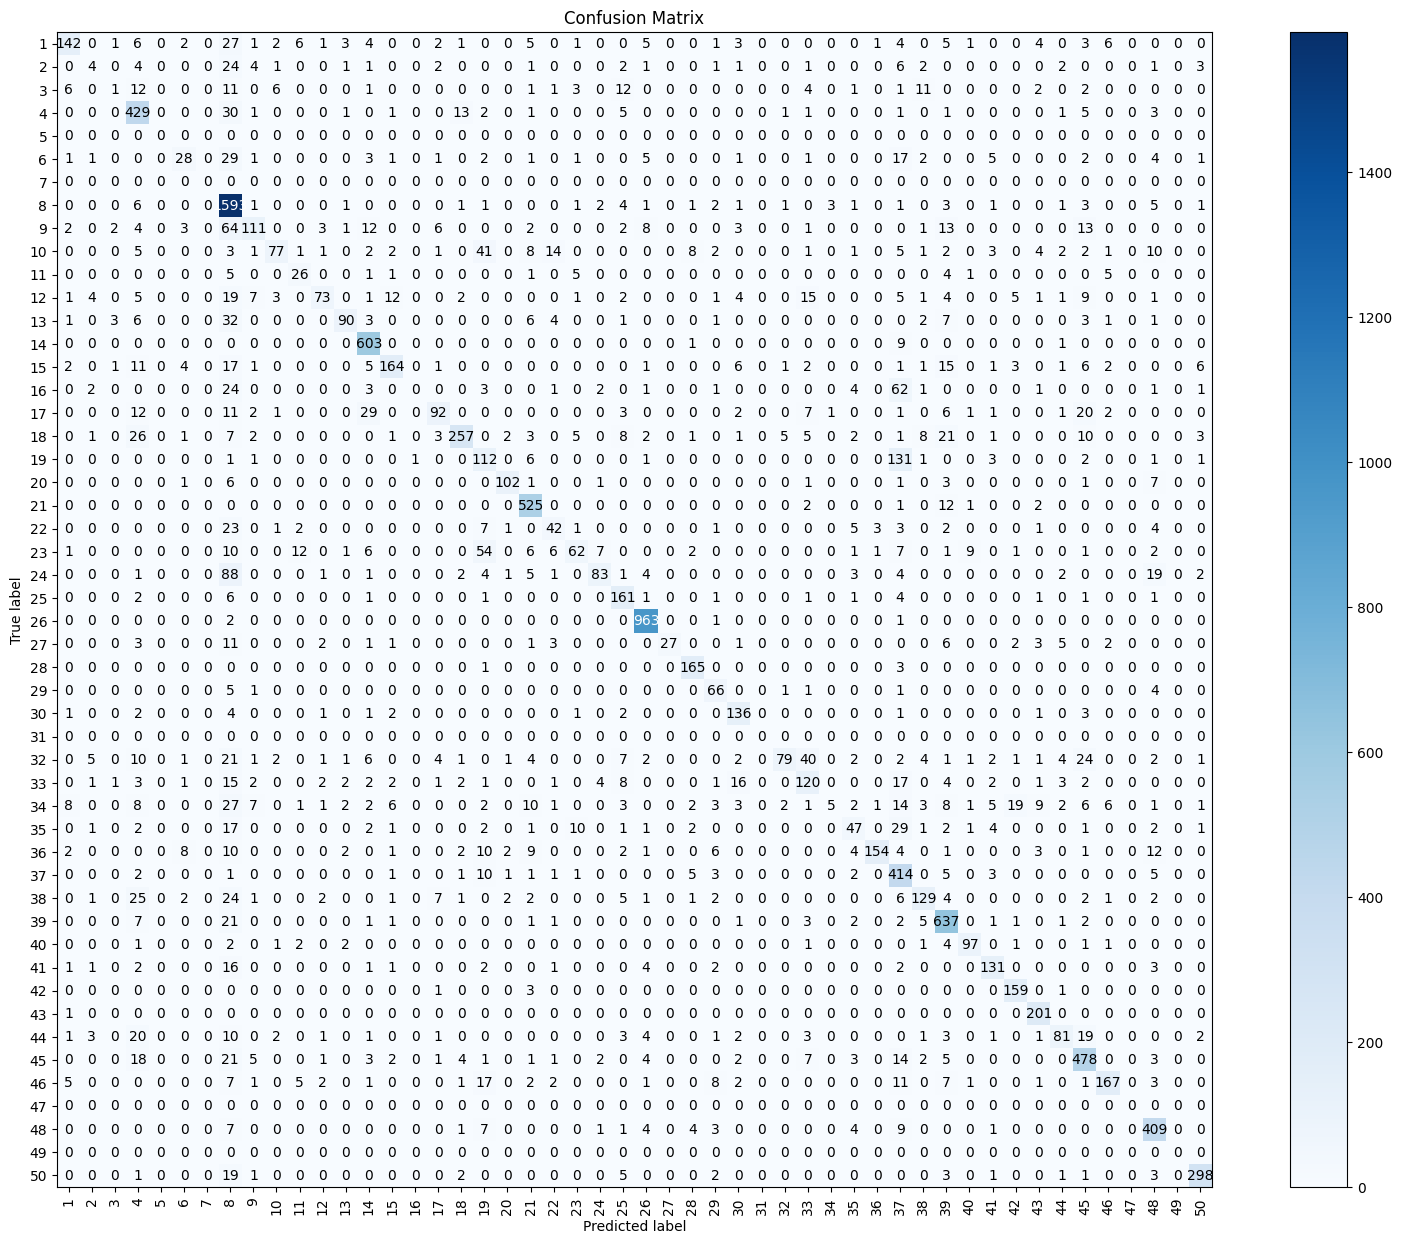

In [88]:
features_new_test_df = pd.DataFrame([extract_features(text) for text in new_test_df['text']])
features_new_test_df["american_word_diff"] = features_new_test_df["text"].apply(american_word_count)

x_test = features_new_test_df[features]

ctv = CountVectorizer(max_features=10000)
x_test_ctv = ctv.fit_transform(x_test['text'])

# Caratteristiche stilometriche
x_test_stylometric = csr_matrix(x_test.drop(columns=['text']), dtype=float)

# Combinazione delle caratteristiche
x_test = hstack([x_test_ctv, x_test_stylometric])

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, max_depth=2, n_estimators=2000, learning_rate=0.25)

y_train_encoded = label_encoder.fit_transform(y_train)

xgb_model.fit(x_train, y_train_encoded)
y_pred = xgb_model.predict(x_test)
y_pred_original = label_encoder.inverse_transform(y_pred)

f1 = f1_score(new_test_author, y_pred_original, average='micro')
XGB_f1_scores.append(f1)
print("F1 Score Gradient Boosting:", f1)

skplt.metrics.plot_confusion_matrix(
    new_test_author,
    y_pred_original,
    labels=range(1, 51),
    x_tick_rotation=90,
    figsize=(20,15))

In [89]:
XGB_f1_scores_df = pd.DataFrame({'validation_set': [BOW_Stylo_f1_scores[3]],'test_df': [XGB_f1_scores[0]], 'new_test_df': [XGB_f1_scores[1]]})
display(HTML(XGB_f1_scores_df.to_html(index=False)))

validation_set,test_df,new_test_df
1.0,0.502217,0.760462
